# Analysis of Travel Dataset: Guide to India's Must See Places

In [57]:
#Import libarys
import pandas as pd
import math
import pingouin as pg
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy as sp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.express as px
import plotly
import plotly.graph_objects as go
from plotly.graph_objs import Scatter, Figure, Histogram, Layout, Bar
plotly.offline.init_notebook_mode(connected = True)
from plotly.subplots import make_subplots
from geopy.geocoders import Nominatim
from pypalettes import load_cmap
from pypalettes import get_hex
from geopy.distance import geodesic

## Introduction

This dataset was downloaded from [Kaggle](https://www.kaggle.com/datasets/saketk511/travel-dataset-guide-to-indias-must-see-places).

The data is loaded into the noteboook, and the head and shape is displayed for initial inspection.

Through the process of the following inspection, it is found that the dataset is completely without NaN values. The na_filter is set to False to avoid filtering string of 'None' in the variable that describes what day an attraction is not open.

In [59]:
#File renamed to 'data.csv' and saved in current working directory
with open('data.csv') as x:
    ncols = len(x.readline().split(','))

df_raw = pd.read_csv('data.csv', usecols=range(1,ncols), na_filter = False)

In [60]:
#Make a copy of the dataset to avoid the need to re-import
df = df_raw.copy()

In [61]:
#display dataframe head for initial inspection
df.head()

Zone  State   City                  Name          Type  \
0  Northern  Delhi  Delhi            India Gate  War Memorial   
1  Northern  Delhi  Delhi        Humayun's Tomb          Tomb   
2  Northern  Delhi  Delhi     Akshardham Temple        Temple   
3  Northern  Delhi  Delhi  Waste to Wonder Park    Theme Park   
4  Northern  Delhi  Delhi         Jantar Mantar   Observatory   

  Establishment Year  time needed to visit in hrs  Google review rating  \
0               1921                          0.5                   4.6   
1               1572                          2.0                   4.5   
2               2005                          5.0                   4.6   
3               2019                          2.0                   4.1   
4               1724                          2.0                   4.2   

   Entrance Fee in INR Airport with 50km Radius Weekly Off   Significance  \
0                    0                      Yes       None     Historical   
1                   30                      Yes       None     Historical   
2                   60                      Yes       None      Religious   
3                   50                      Yes     Monday  Environmental   
4                   15                      Yes       None     Scientific   

  DSLR Allowed  Number of google review in lakhs Best Time to visit  
0          Yes                              2.60            Evening  
1          Yes                              0.40          Afternoon  
2           No                              0.40          Afternoon  
3          Yes                              0.27            Evening  
4          Yes                              0.31            Morning

In [62]:
# Dataset shape
print(df.shape)
 
rows, columns = df.shape
print(f"The dataset comprises {rows} properties described across {columns} attributes.")

(325, 15)
The dataset comprises 325 properties described across 15 attributes.




<ul>
    <li>Data types are analysed to shape analysis approach.

In [64]:
#Determine the data type for each feature
data_types = df.dtypes
 
# View a few datatypes from the dataset
print(data_types)

Zone                                 object
State                                object
City                                 object
Name                                 object
Type                                 object
Establishment Year                   object
time needed to visit in hrs         float64
Google review rating                float64
Entrance Fee in INR                   int64
Airport with 50km Radius             object
Weekly Off                           object
Significance                         object
DSLR Allowed                         object
Number of google review in lakhs    float64
Best Time to visit                   object
dtype: object


<ul>
    <li>
        Note that 'Establishment Year' is object, which is string type. This will need to be coverted to numerical for analysis.
    </li>

In [66]:
# Tally the total by data type
type_counts = data_types.value_counts()
 
print(type_counts)

object     11
float64     3
int64       1
Name: count, dtype: int64


<ul>
    <li>Visualizing the Missing Values

In [68]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

# Combining the counts and percentages into a DataFrame for better visualization
missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})

# Sorting the DataFrame by the percentage of missing values in descending order
missing_info = missing_info.sort_values(by='Percentage', ascending=False)

# Display columns with missing values
print(missing_info[missing_info['Missing Values'] > 0])

Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


<ul>
    <li>The dataset has no missing values. 

In [70]:
# Check the structure of the dataset
print("\nStructure of the dataset:")
print(df.info())


Structure of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Zone                              325 non-null    object 
 1   State                             325 non-null    object 
 2   City                              325 non-null    object 
 3   Name                              325 non-null    object 
 4   Type                              325 non-null    object 
 5   Establishment Year                325 non-null    object 
 6   time needed to visit in hrs       325 non-null    float64
 7   Google review rating              325 non-null    float64
 8   Entrance Fee in INR               325 non-null    int64  
 9   Airport with 50km Radius          325 non-null    object 
 10  Weekly Off                        325 non-null    object 
 11  Significance                      325 non-nu

## Clean-up and transformations
Modify the dataframe to simplify and improve the data analysis approach.

In [72]:
# Convert column names to lowercase
df.columns = df.columns.str.lower()

#rename columns to make them easier to work with
df = df.rename(columns = {'establishment year':'year', 'time needed to visit in hrs':'time', 'google review rating':'rating',
                         'entrance fee in inr':'fee', 'airport with 50km radius':'airport', 'weekly off':'off',
                         'dslr allowed':'camera', 'number of google review in lakhs':'reviews', 'best time to visit':'visit'})

# convert Binary variables to numerical
df['camera_num'] = df['camera'].astype('category').cat.codes

df['airport_num'] = df['airport'].astype('category').cat.codes

# create binary column for 'visit' == 'Anytime'
df['anytime'] = pd.get_dummies(df['visit'])['Anytime']#.astype(int)

# Convert 'Establishment Year' to numeric based on conditions
df['year_num'] = df['year'].apply(lambda x: int(re.findall('[0-9-]+', x)[0]) * 100 if re.search("century", x) else (
    int(re.findall('[0-9-]+', x)[0])) if re.findall('[0-9-]+', x) != [] else np.nan)

# Clean visit variable category types
df['visit'] = df['visit'].str.strip().replace('All','Anytime').astype('category')

# Convert all elements in the 'city' column to Cap Case
df['city'] = df['city'].str.title()

In [73]:
df.shape

(325, 19)

## Feature Engineering
Additional numerical variables are created based on the existing variables.

'ratings' is normalized and log-scale columns are created for skewed variables.

In [75]:
#Add column for time periods
df['year_group'] = df['year_num'].apply(lambda x: 'Prehistoric' if x <= -3300 else (
    'Bronze Age' if x <= -1800 else ('Iron Age' if x <= -200 else (
        'Classical Period' if x <= 650 else ('Early Medieval Period' if x <= 1200 else (
        'Late Medieval Period' if x <= 1526 else ('Early Medieval Period' if x <= 1858 else(
            'Late Modern and Contemporary Period' if x <= 1947 else (
            'Independence and Partition' if x > 1947 else 'Unknown'
            )))))))))

#Create column for ratio of fee to time ("Value")
df['cost_ratio'] = df['fee'] / df['time']

#Normalize ratings column
scaler = StandardScaler()
df['rating_norm'] = scaler.fit_transform(df[['rating']])

#log scale skewed variables
df['fee_log'] = np.log1p(df['fee'])

df['reviews_log'] = np.log1p(df['reviews'])

df['cost_ratio_log'] = np.log1p(df['cost_ratio'])

In [76]:
clat = []
clon = []
cities = []

geolocator = Nominatim(user_agent="my_geocoder")


for city in df['city'].unique():
    
    location = geolocator.geocode(city)

    if location:
        clat.append(location.latitude)
        clon.append(location.longitude)
        cities.append(city)
    else:
        clat.append(np.nan)
        clon.append(np.nan)
        cities.append(city)

In [77]:
cgeo = pd.DataFrame({'city':cities, 'lat':clat, 'lon':clon}).set_index('city')

cgeo.loc['Dalhousie'] = [32.53, 75.98]
cgeo.loc['Auli'] = [30.52892, 79.57026]
cgeo.loc['Manas'] = [26.716667, 90.933333]
cgeo.loc['Barot'] = [32.036389, 76.8475]
cgeo.loc['Shoja'] = [31.5672, 77.3705]

df_geo = pd.merge(df,cgeo, on = 'city')

## Descriptive Statistics

Sanity check on descriptive statistics

In [79]:
# Descriptive statistics for numerical columns
print(df.describe())

             time      rating          fee     reviews  camera_num  \
count  325.000000  325.000000   325.000000  325.000000  325.000000   
mean     1.807692    4.486154   115.809231    0.408438    0.815385   
std      0.971398    0.274580   530.859785    0.646668    0.388584   
min      0.500000    1.400000     0.000000    0.010000    0.000000   
25%      1.000000    4.400000     0.000000    0.059000    1.000000   
50%      1.500000    4.500000     0.000000    0.170000    1.000000   
75%      2.000000    4.600000    40.000000    0.500000    1.000000   
max      7.000000    4.900000  7500.000000    7.400000    1.000000   

       airport_num     year_num   cost_ratio   rating_norm     fee_log  \
count   325.000000   213.000000   325.000000  3.250000e+02  325.000000   
mean      0.698462  1561.661972    43.621720 -9.073084e-16    1.834637   
std       0.459634   702.597182   185.167754  1.001542e+00    2.291259   
min       0.000000 -3500.000000     0.000000 -1.125688e+01    0.000000   

## Univariate Analyiss

Proceeding with univariate analysis

In [81]:
def univariate(x, df=df, outliers = 'yes'):
    """
    Display univariate information for numerical variables.
    
    Parameters
    ----------
    x : string
        The name of the numerical variable for analyis
    df : dataframe, optional
        The dataframe to analyze, default value = df
    outliers : string, optional
        'yes' to display outliers, 'no' to filter them, default value = 'yes'
    
    Returns
    -------
    Dataframe sorted by x column, largest values
    
    Dataframe sorted by x column, smallest values
    
    histogram of x with boxplot above
    
    """
    #display dataframe sorted by x column, largest values
    display(df.sort_values(x, ascending = False).head())

    #display dataframe sorted by x column, smallest values. If all values are 0, do not display
    if df.sort_values(x, ascending = True).head()[x].sum() > 0:
        display(df.sort_values(x, ascending = True).head())

    #filter outliers if enabled
    if outliers == 'no':
        df = df.loc[df[[x]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #display histogram of x variable
    fig = px.histogram(df, x=x, title = 'Histogram of ' + x, nbins = int(len(df) ** (1 / 2)), marginal = 'box', hover_name = 'name')
    fig.show()

zone    state           city                             name  \
196  Northern   Ladakh            Leh                      Pangong Tso   
72    Western  Gujarat  Rann Of Kutch                       Rann Utsav   
92   Northern   Punjab       Amritsar  Golden Temple (Harmandir Sahib)   
94   Northern   Punjab       Amritsar                     Wagah Border   
207  Northern   Ladakh           Dras                Dras War Memorial   

                type     year  time  rating   fee airport  ... camera_num  \
196             Lake  Unknown   2.0     4.9    20     Yes  ...          1   
72          Cultural  Unknown   3.0     4.9  7500     Yes  ...          1   
92    Religious Site     1604   1.5     4.9     0     Yes  ...          1   
94   Border Crossing     1950   2.0     4.8     0     Yes  ...          1   
207     War Memorial  Unknown   1.0     4.8     0      No  ...          1   

    airport_num anytime  year_num                  year_group  cost_ratio  \
196           1   False       NaN                     Unknown        10.0   
72            1   False       NaN                     Unknown      2500.0   
92            1   False    1604.0       Early Medieval Period         0.0   
94            1   False    1950.0  Independence and Partition         0.0   
207           0   False       NaN                     Unknown         0.0   

     rating_norm   fee_log  reviews_log cost_ratio_log  
196     1.509522  3.044522     0.139762       2.397895  
72      1.509522  8.922792     0.095310       7.824446  
92      1.509522  0.000000     1.064711       0.000000  
94      1.144767  0.000000     0.157004       0.000000  
207     1.144767  0.000000     0.011929       0.000000  

[5 rows x 25 columns]

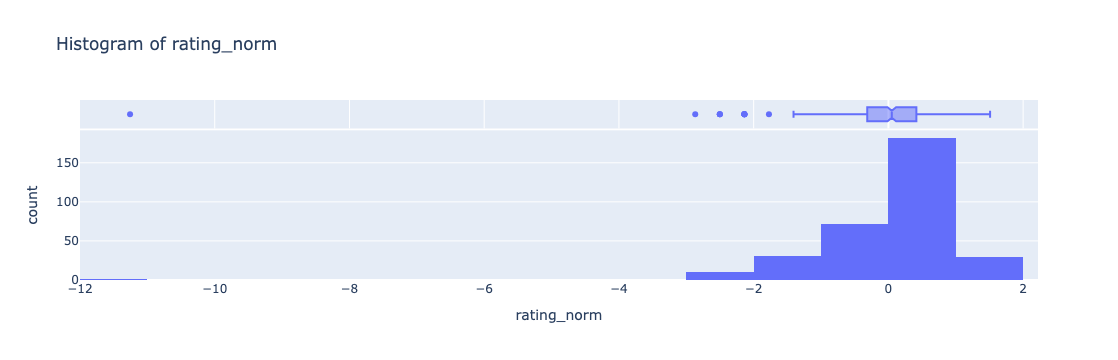

In [201]:
univariate('rating_norm')

## Correlation Analysis

In [83]:
def corr_matrix(x = None, y = None, df=df):
    """
    Display correlation dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation table
    
    """

    #Apply correlation matrix to entire dataframe, unless x and y variables are provided for filter
    if x == None:
        df = df
    else:
        df = df[df[x] == y]

    #Set plot size
    plt.figure(figsize=(10,8))

    #Create correlation matrix
    corr_matrix = df.corr(numeric_only = True)

    #Convert correlation matrix to heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

    #Set correlation matrix title
    plt.title('Correlation Matrix')

    #display correlation matrix
    plt.show()

def corr_table(x = None, y = None, df=df, t_min = 0.3, t_max = 1):
    """
    Display correlation dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation table
    
    """
    #Apply correlation matrix to entire dataframe, unless x and y variables are provided for filter
    
    
    if x == None:
        df = df
    else:
        df = df[df[x] == y]

    #Create correlation matrix
    corr = df.corr(numeric_only = True)

    #convert correlation matrix into list of lists
    result = []
    for row in corr.index:
        for col in corr:
            if row != col:
                result.append([row, col, corr[col][row]])
    
    #convert list into dataframe
    corr_df = pd.DataFrame(result, columns = ['var_1','var_2','corr'])

    #Sort dataframe on correlation
    corr_df = corr_df.sort_values('corr', ascending = False)
    
    #Filter variables that are directly correlated 
    corr_df = corr_df[~(corr_df['var_1'].str.contains('rating') & corr_df['var_2'].str.contains('rating'))]
    corr_df = corr_df[~(corr_df['var_1'].str.contains('cost|fee') & corr_df['var_2'].str.contains('cost|fee'))]
    corr_df = corr_df[~(corr_df['var_1'].str.contains('reviews') & corr_df['var_2'].str.contains('reviews'))]

    #Filter duplicate rows
    #corr_df = corr_df.iloc[::2]

    #Filter by minimum and maximum correlation threshold
    corr_df = corr_df[(abs(corr_df['corr']) > t_min) & (abs(corr_df['corr']) <= t_max)]

    #Add columns for category and type
    corr_df['category'] = x
    corr_df['type'] = y

    return corr_df


def corr_info(x = None, y = None, df = df, t_min = 0.3, t_max = 1):
    """
    Display correlation matrix and dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation matrix with heatmap
    
    Correlation table
    
    """
    #Display correlation matrix
    corr_matrix(x, y, df)

    #Display correlation table
    display(corr_table(x, y, df, t_min, t_max))

def corr_cat(x, t_min=0.3, t_max = 1, df=df, f = 3):
    """
    Combine correlation tables across a single variable.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    df : dataframe, optional
        The dataframe to analyze, default value = df
    f : int, optional
        Count of elements by which to filter, default value = 3
    
    Returns
    -------
    
    Combined correlation table
    
    """
    #Create empty dataframe
    corr_cat_df = pd.DataFrame()

    #Filter grouped dataframe by element count
    df = df.groupby(x, observed = False).filter(lambda x: len(x) > f)

    #Loop through types within category, combine dataframes
    for y in df[x].unique():
        temp_df = corr_table(x, y, t_min=t_min, t_max=t_max, df=df)
        corr_cat_df = pd.concat([corr_cat_df, temp_df], axis = 0)

    #Return combined dataframe
    return corr_cat_df

def corr_total(t_min = 0.9, t_max = 1, f = 10, df=df):
    """
    Combine correlation tables across all variables.
    
    Parameters
    ----------
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.9
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    f : int, optional
        Count of elements by which to filter, default value = 10
    
    Returns
    -------
    
    Combined correlation table
    
    """
    #Create empty dataframe
    corr_total_df = pd.DataFrame()

    #Loop through variables within dataframe, combine dataframes
    for x in df.loc[:, df.columns != 'year'].select_dtypes(exclude='number').columns:
        temp_df = corr_cat(x, t_min=t_min, t_max=t_max, f = f, df=df)
        corr_total_df = pd.concat([corr_total_df, temp_df], axis = 0)

    #Sort dataframe on correlation
    corr_total_df = corr_total_df.sort_values('corr', ascending = False)

    #Return combined dataframe
    return corr_total_df

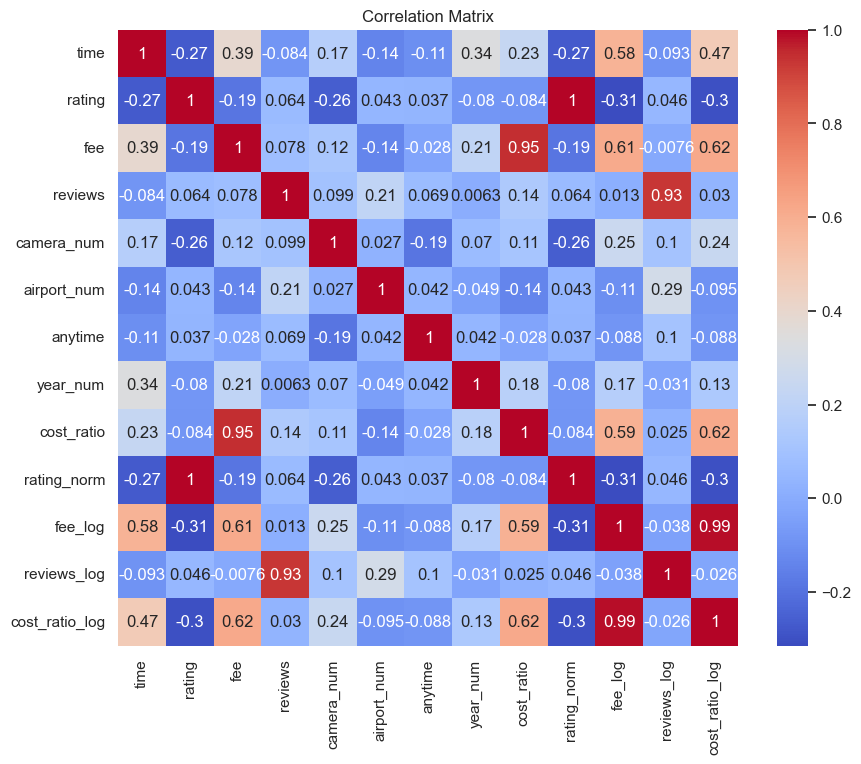

var_1           var_2      corr category  type
120         fee_log            time  0.579462     None  None
9              time         fee_log  0.579462     None  None
144  cost_ratio_log            time  0.472783     None  None
11             time  cost_ratio_log  0.472783     None  None
1              time             fee  0.390704     None  None
24              fee            time  0.390704     None  None
84         year_num            time  0.336223     None  None
6              time        year_num  0.336223     None  None
145  cost_ratio_log          rating -0.301630     None  None
23           rating  cost_ratio_log -0.301630     None  None
119     rating_norm  cost_ratio_log -0.301630     None  None
153  cost_ratio_log     rating_norm -0.301630     None  None
21           rating         fee_log -0.314632     None  None
117     rating_norm         fee_log -0.314632     None  None
121         fee_log          rating -0.314632     None  None
129         fee_log     rating_norm -0.314632     None  None

In [750]:
corr_info(df=df[df['year_num'] > 1400])

In [85]:
corr_total(df=df.drop(['rating_norm', 'reviews', 'fee', 'cost_ratio', 'camera_num', 'airport_num'], axis = 1), t_min = .6, f = 20)

var_1    var_2      corr      category  \
24  fee_log     time  0.659382          type   
3      time  fee_log  0.659382          type   
24  fee_log     time  0.649772          zone   
3      time  fee_log  0.649772          zone   
3      time  fee_log  0.634382  significance   
24  fee_log     time  0.634382  significance   
3      time  fee_log  0.628243    year_group   
24  fee_log     time  0.628243    year_group   
3      time  fee_log  0.619755          zone   
24  fee_log     time  0.619755          zone   
3      time  fee_log  0.619307    year_group   
24  fee_log     time  0.619307    year_group   

                                   type  
24                                 Fort  
3                                  Fort  
24                              Eastern  
3                               Eastern  
3                          Recreational  
24                         Recreational  
3   Late Modern and Contemporary Period  
24  Late Modern and Contemporary Period  
3                               Western  
24                              Western  
3            Independence and Partition  
24           Independence and Partition

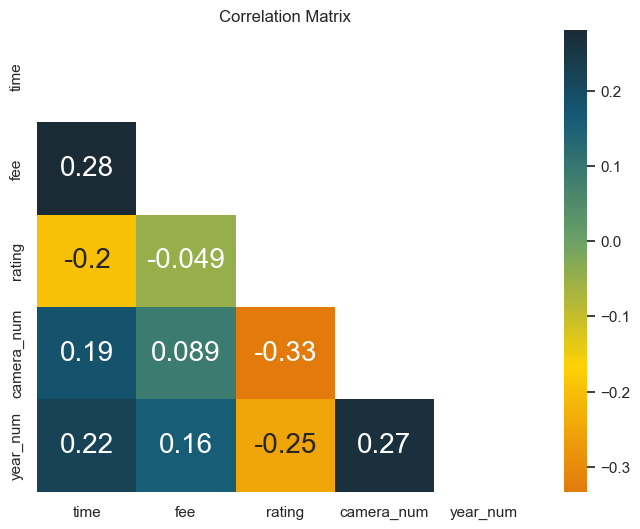

In [86]:
x = None
y = None
sns.set_theme(style="white")
cmap = load_cmap('Balistapus_undulatus', type='continuous', type_warning = False)

temp_df = df.drop(['rating_norm', 'reviews_log', 'fee_log', 'cost_ratio_log'], axis = 1)
temp_df = df[['time','fee','rating','camera_num','year_num']]

#Set plot size
plt.figure(figsize=(8,6))

#Create correlation matrix
corr_matrix_df = temp_df.corr(numeric_only = True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix_df)
mask[np.triu_indices_from(mask)] = True

#Convert correlation matrix to heatmap
sns.heatmap(corr_matrix_df, annot=True, cmap=cmap, mask=mask, annot_kws = {'size': 20}, center = 0)

#Set correlation matrix title
plt.title('Correlation Matrix')

#display correlation matrix
plt.show()

## Bivariate Analysis

In [88]:
def bivar_box(x, y, df=df, text='name', cat=None):
    """
    Display boxplots for discrete numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for outlier points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    
    Returns
    -------
    
    Box plots for each discrete number category.
    
    """
    #filter outliers
    temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #create figure
    fig = px.box(temp_df, x=x, y=y, hover_name=text, color = cat, title = y + " vs " + x)

    return fig

def outliers(x, y, df=df):
    """
    Create dataframe of outliers based on category and type.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Dataframe of outliers.
    
    """

    #create outliers dataframe, remove NaNs
    outliers_df = df[[x, y]].dropna()

    #filter outliers from dataframe
    outliers_df = outliers_df.loc[~outliers_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #merge filtered dataframe onto original dataframe
    outliers_df = outliers_df.merge(df, how = 'left', left_index = True, right_index = True, 
                              suffixes = ['', '_y'])[['name', x, y]].sort_values(by = y)
    
    return outliers_df

def bivar_sca(x, y, df=df, text = 'name', cat = None):
    """
    Display scatter plot for numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    
    Returns
    -------
    
    Scatter plot for numerical category.
    
    """
    #filter outliers
    temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #create figure
    fig = px.scatter(temp_df, x=x, y=y, color = cat, hover_name=text, title = y + " vs " + x)

    return fig


def bivariate(x, y, df=df, text = 'name', cat = None, type = 'sca'):
    """
    Display plot for numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    type : string, optional
        Type of plot to produce, default value = 'sca'
        Produce scatter plot : type = 'sca'
        Produce box plot : type = 'box'
    
    Returns
    -------
    
    Plot and outliers table.
    
    """

    #Display either scatter or box plot, depending on value of 'type'
    if type == 'sca':
        bivar_sca(x, y, df, text, cat).show()
    elif type == 'box':
        bivar_box(x, y, df, text, cat).show()
    #return outliers dataframe
    return display(outliers(x, y))
    


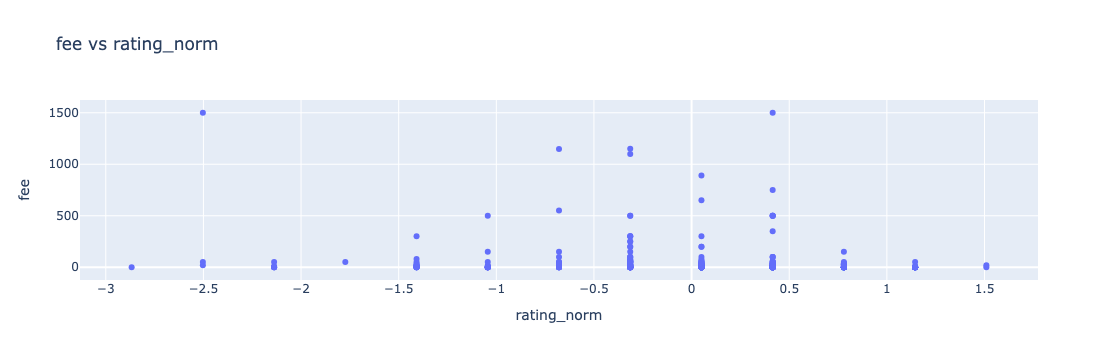

name  rating_norm   fee
26            Imagicaa   -11.256880  1149
47        Eden Gardens    -1.408513  2500
161   Paragliding Site     1.144767  2500
68   Gir National Park     0.050504  3500
72          Rann Utsav     1.509522  7500

In [89]:
bivariate('rating_norm', 'fee')

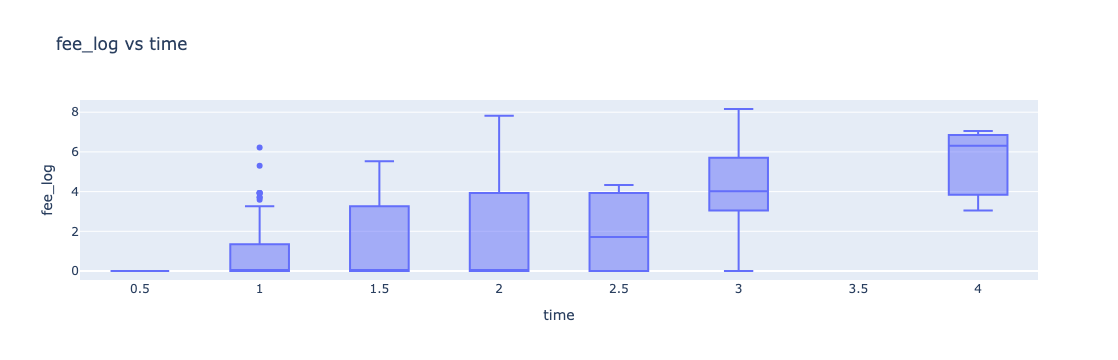

name  time   fee_log
162              Triund Trek   5.0  0.000000
200            Amarnath Cave   6.0  0.000000
198             Vaishno Devi   5.0  0.000000
2          Akshardham Temple   5.0  4.110874
15   National Science Centre   5.0  4.262680
180        Valley of Flowers   5.0  5.017280
78              Science City   7.0  6.216606
110  Wonderla Amusement Park   5.5  6.621406
24               Essel World   5.0  7.047517
26                  Imagicaa   5.0  7.047517
167          Kufri Fun World   5.0  7.313887
72                Rann Utsav   3.0  8.922792

In [90]:
bivariate('time', 'fee_log', type='box')

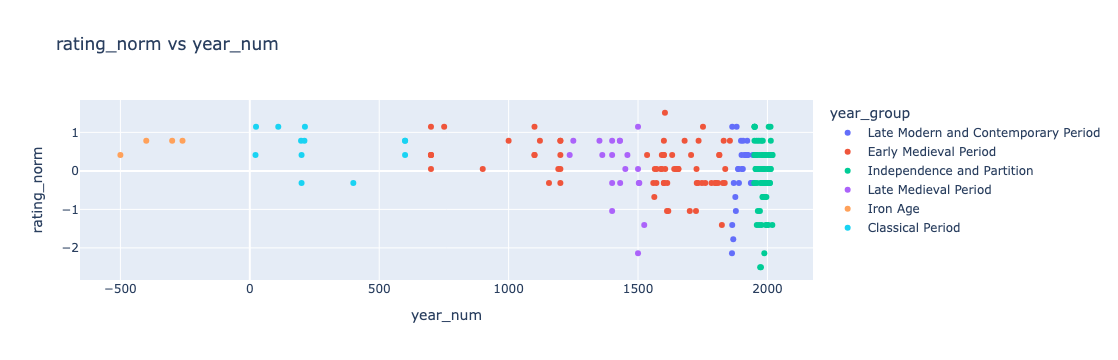

name  year_num  rating_norm
26                       Imagicaa    2013.0   -11.256880
229                 Barabati Fort    -987.0     0.050504
136  Khajuraho Group of Monuments    -850.0     0.780013
140     Mahakaleshwar Jyotirlinga   -3500.0     1.144767
174              Badrinath Temple    -820.0     1.144767

In [223]:
bivariate('year_num', 'rating_norm', cat = 'year_group')

In [143]:
loc = 0
f = 10
t_min = 0.9
t_max = 1
temp_df = df


temp_df = temp_df.drop(['anytime', 'camera_num', 'airport_num'], axis = 1)


temp_df = corr_total(t_min = t_min, t_max = t_max, f = f, df=temp_df)

temp_df = temp_df[temp_df['var_2'] != 'year_num']

#temp_df = temp_df[(temp_df['var_1'] == 'rating_norm') | (temp_df['var_2'] == 'rating_norm')]

#temp_df = temp_df.iloc[::2]

temp_df

var_1           var_2      corr category           type
42    year_num         fee_log  0.996861    state            Goa
42    year_num         fee_log  0.996861     city            Goa
44    year_num  cost_ratio_log  0.996861    state            Goa
40    year_num      cost_ratio  0.996861    state            Goa
44    year_num  cost_ratio_log  0.996861     city            Goa
40    year_num      cost_ratio  0.996861     city            Goa
38    year_num             fee  0.996861     city            Goa
38    year_num             fee  0.996861    state            Goa
29     reviews             fee  0.932003    state  Uttar Pradesh
20         fee         reviews  0.932003    state  Uttar Pradesh
48  cost_ratio         reviews  0.930288    state  Uttar Pradesh
31     reviews      cost_ratio  0.930288    state  Uttar Pradesh
45  cost_ratio            time  0.922579     type      Waterfall
4         time      cost_ratio  0.922579     type      Waterfall
1         time             fee  0.914410     type      Waterfall
18         fee            time  0.914410     type      Waterfall
29     reviews             fee  0.912657     zone        Central
20         fee         reviews  0.912657     zone        Central
48  cost_ratio         reviews  0.911177     zone        Central
31     reviews      cost_ratio  0.911177     zone        Central
41    year_num     rating_norm -0.980883     type           Lake
37    year_num          rating -0.980883     type           Lake

state
Goa
0


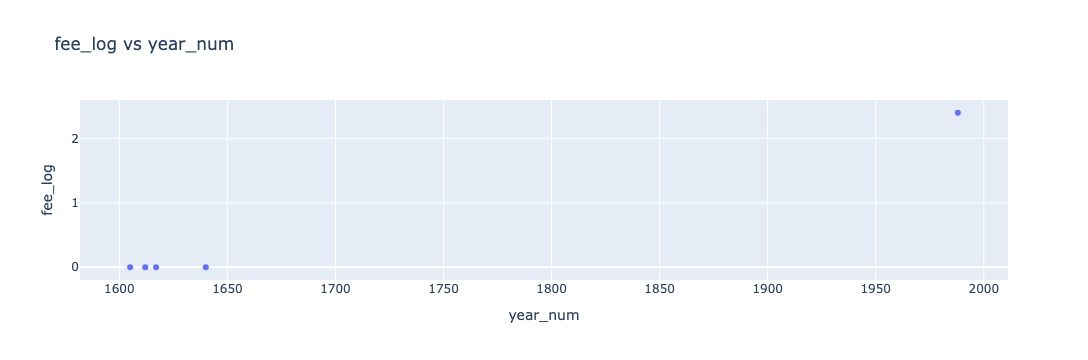

city
Goa
1


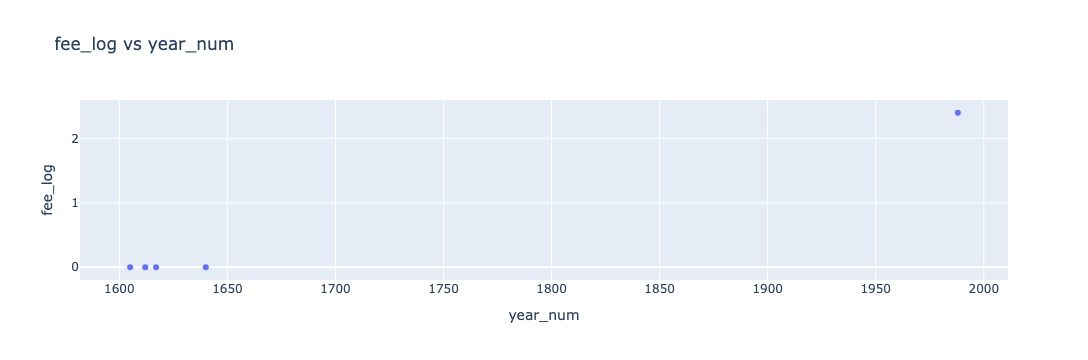

state
Goa
2


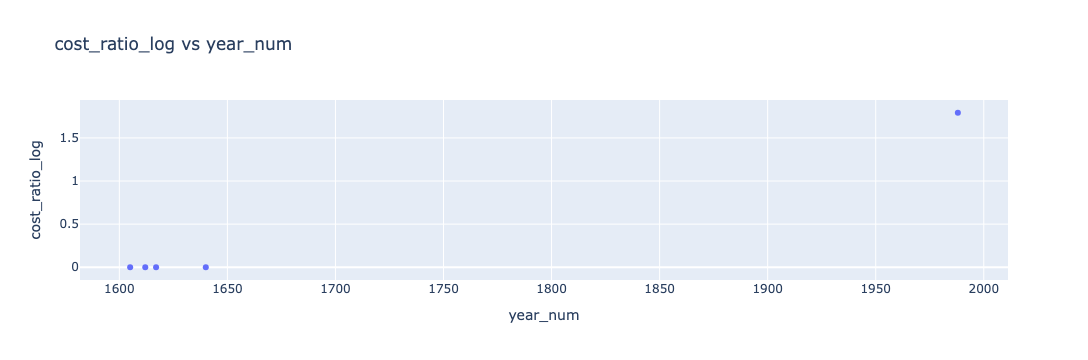

state
Goa
3


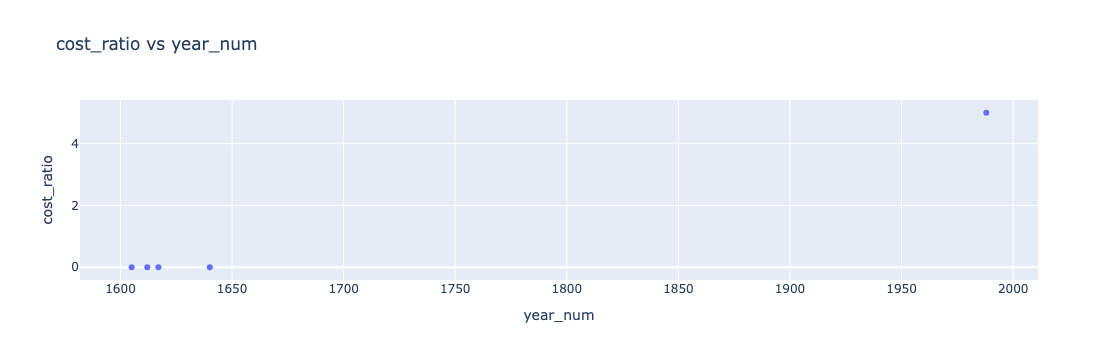

city
Goa
4


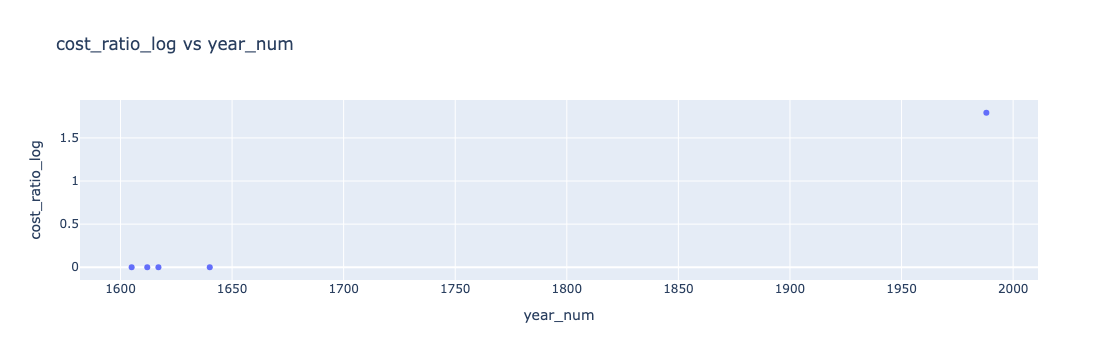

city
Goa
5


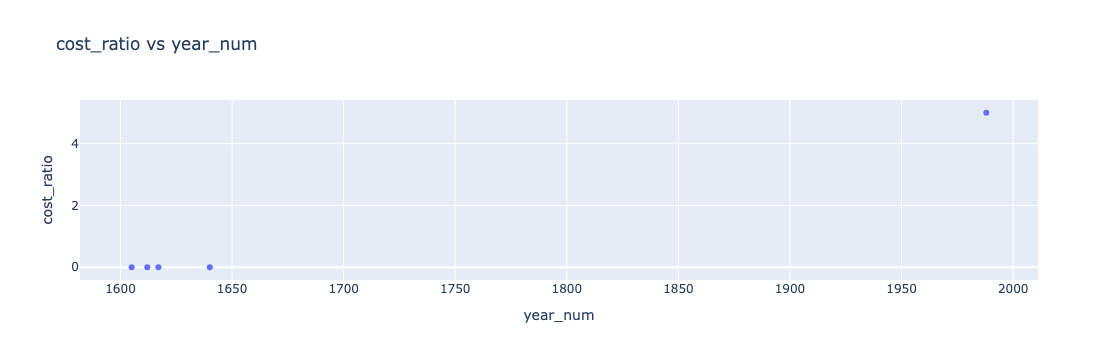

city
Goa
6


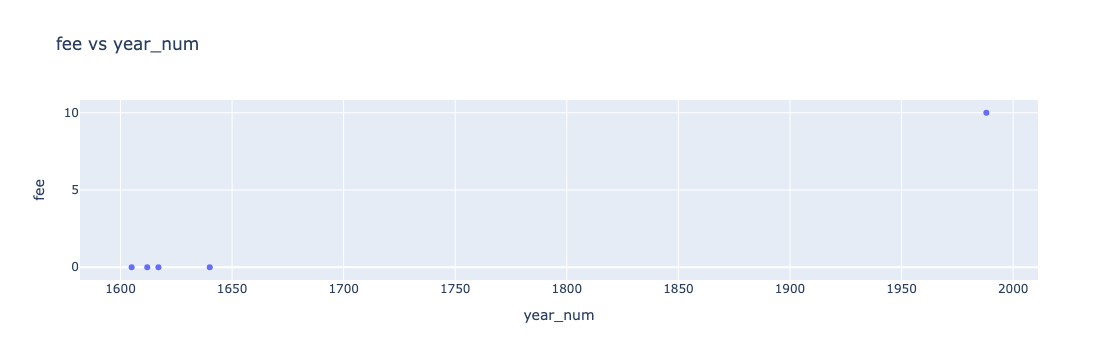

state
Goa
7


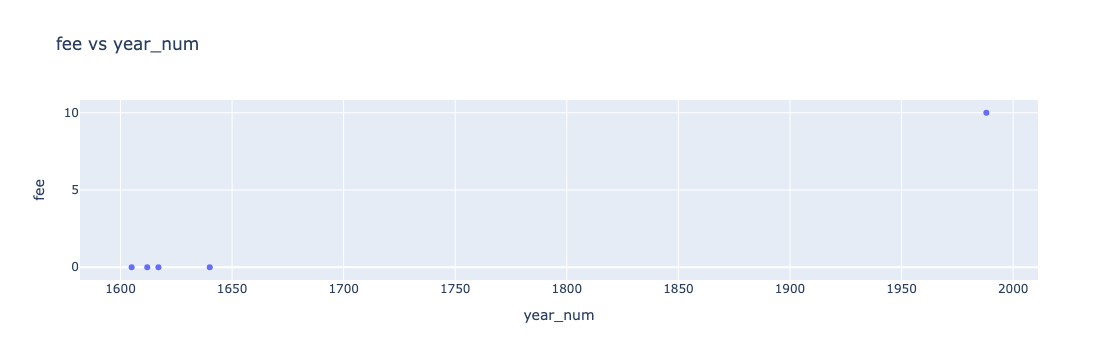

state
Uttar Pradesh
8


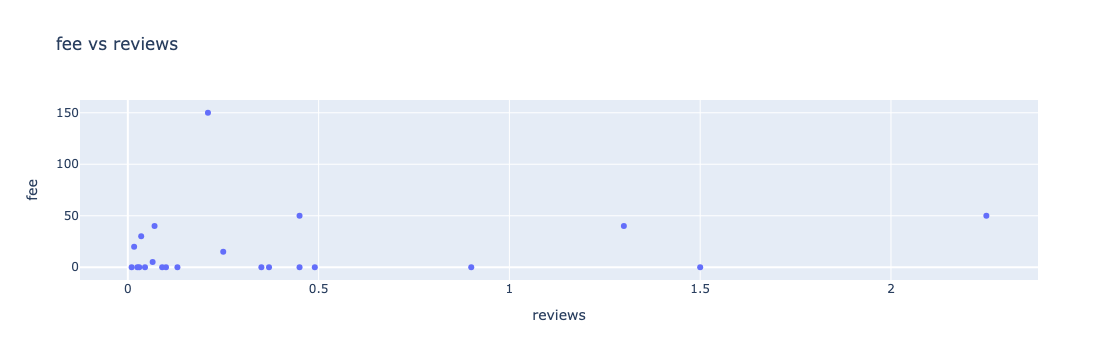

state
Uttar Pradesh
9


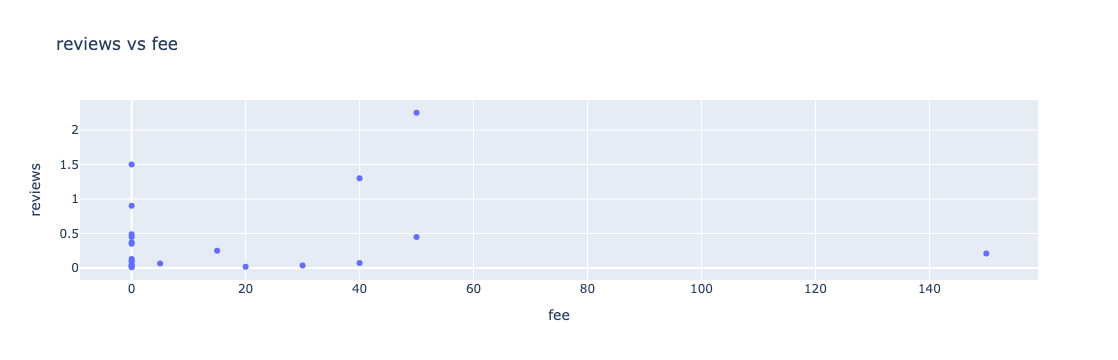

state
Uttar Pradesh
10


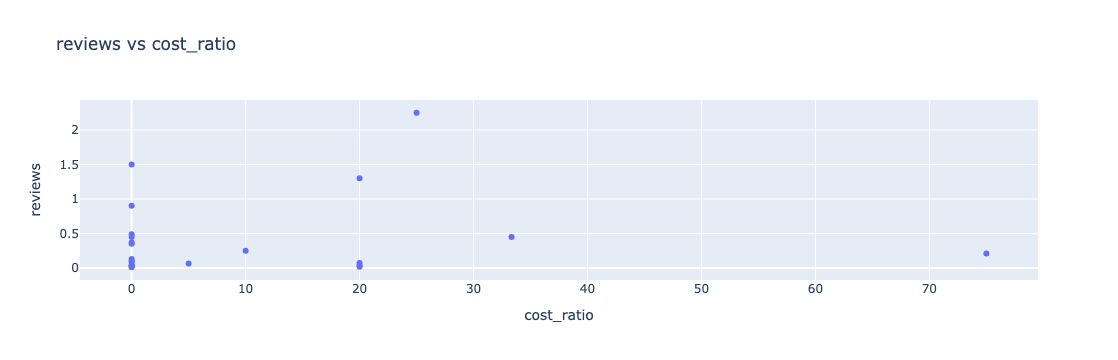

state
Uttar Pradesh
11


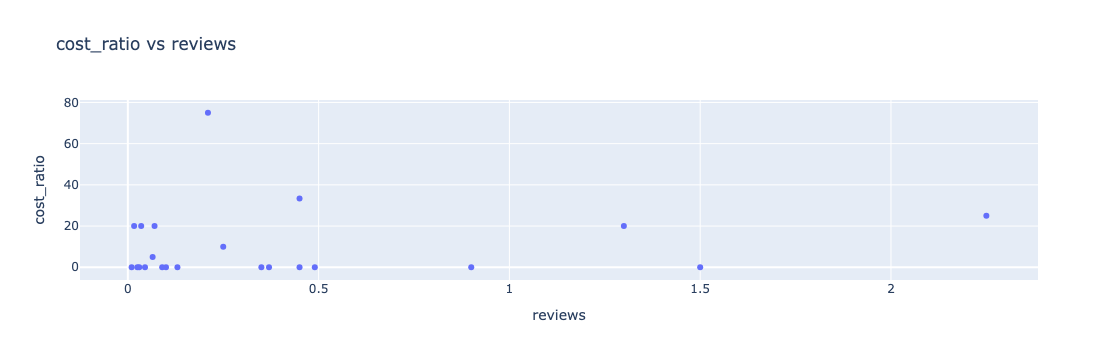

type
Waterfall
12


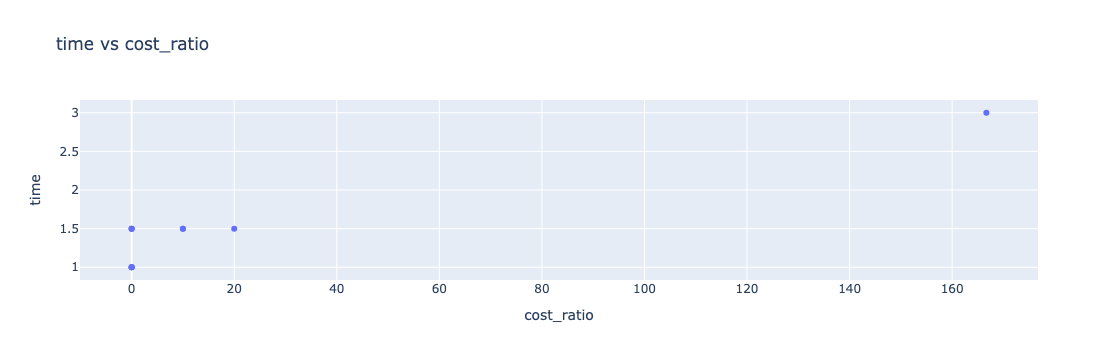

type
Waterfall
13


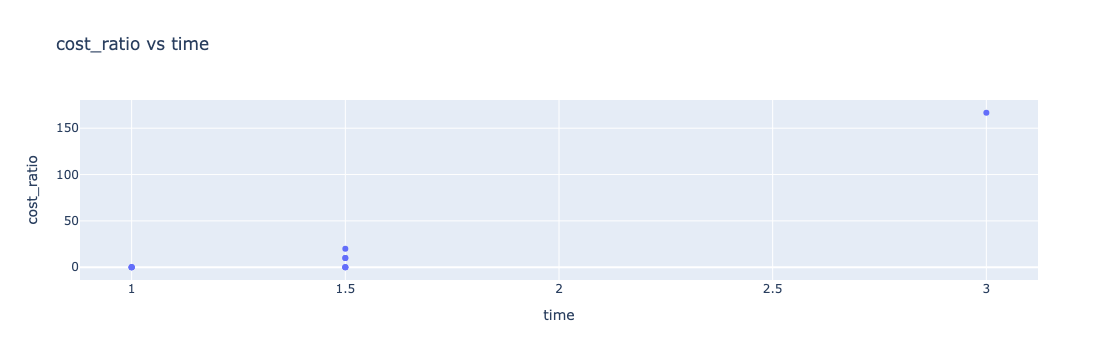

type
Waterfall
14


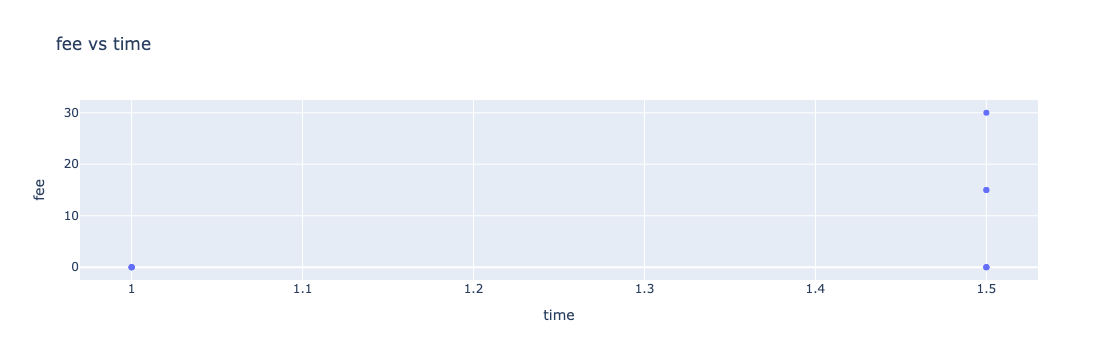

type
Waterfall
15


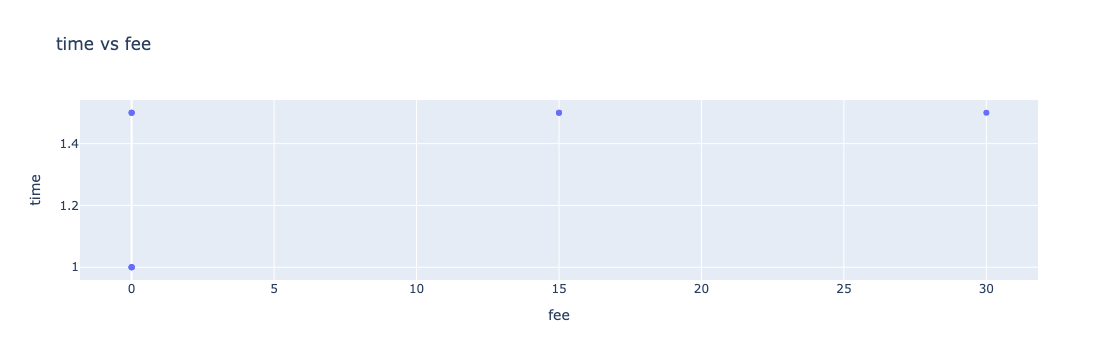

zone
Central
16


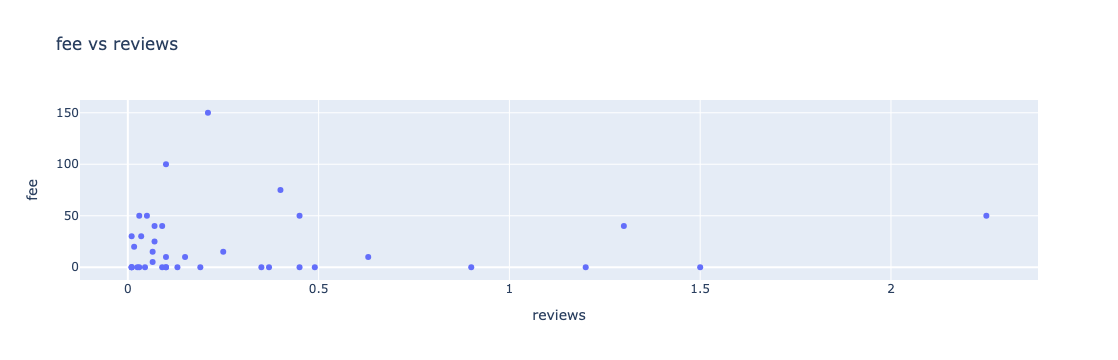

zone
Central
17


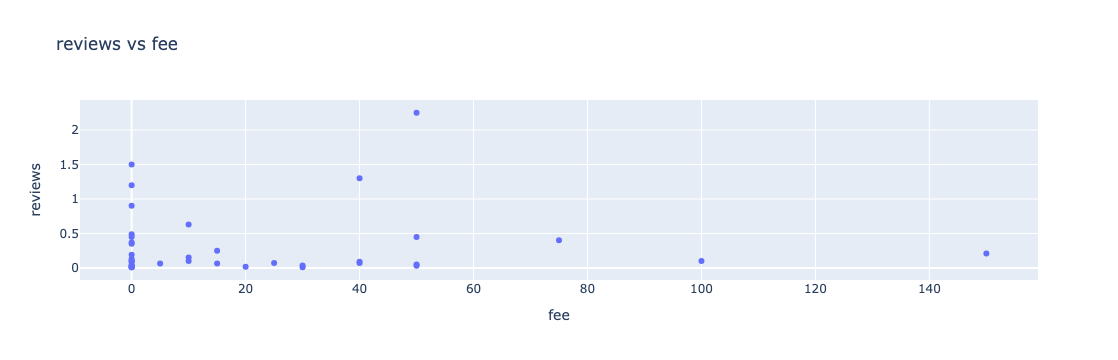

zone
Central
18


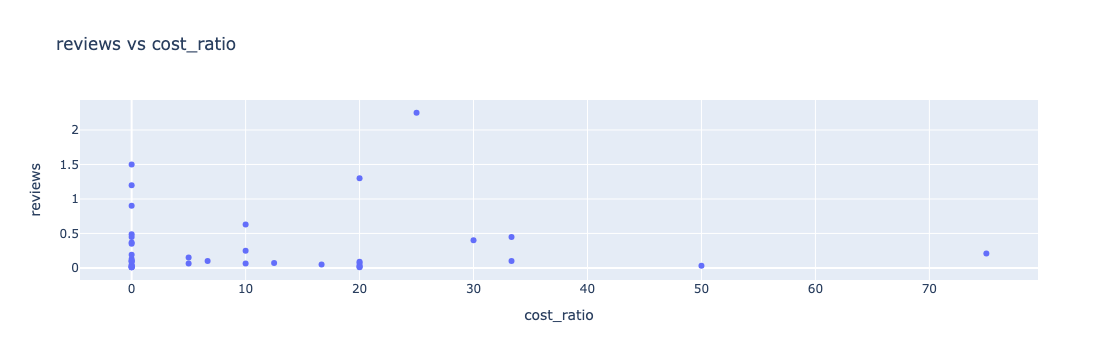

zone
Central
19


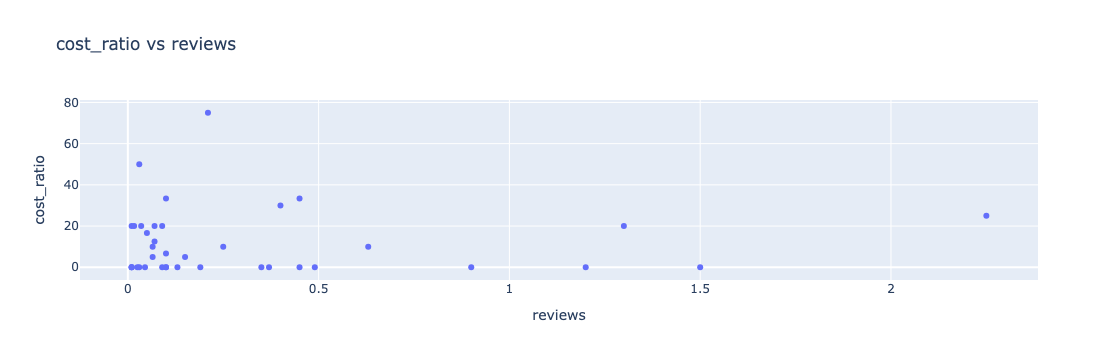

type
Lake
20


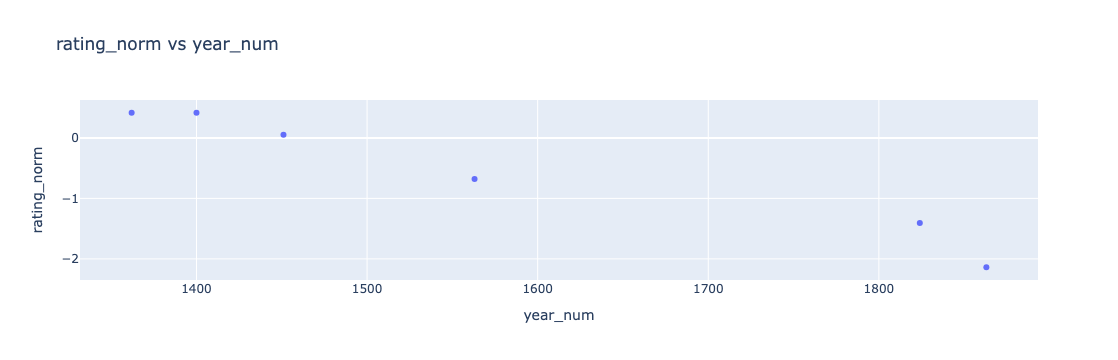

type
Lake
21


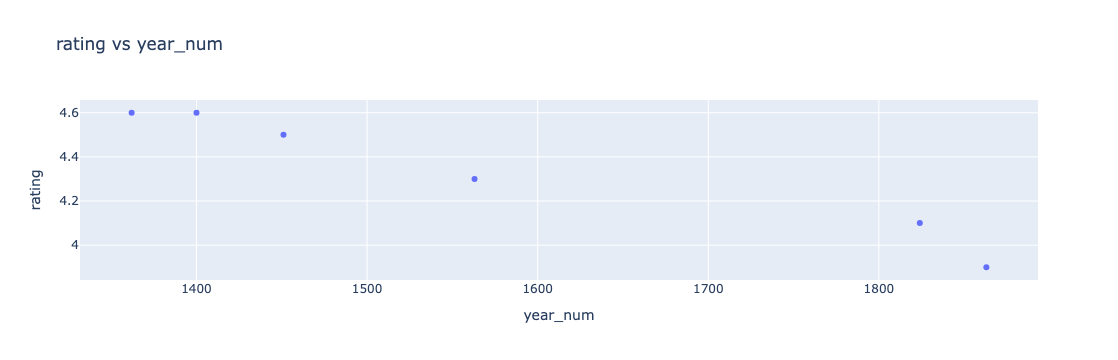

In [145]:
loc = 0

for loc in range(0, len(temp_df)):
    var_1, var_2, corr, category, type = temp_df.iloc[loc]
    print(category)
    print(type)
    print(loc)
    display(bivar_sca(var_1, var_2, df = df[df[category] == type]))
    loc += 1

Categorical analysis

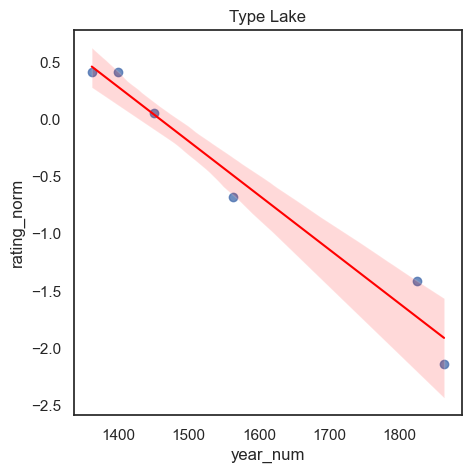

In [137]:
fig, ax = plt.subplots(figsize=(5, 5))
x = 'year_num'
y = 'rating_norm'

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
temp_df= temp_df[temp_df['type'] == 'Lake']

sns.regplot(
    x=temp_df["year_num"],
    y=temp_df["rating_norm"],
    line_kws={"color": "red", "linewidth": 1.5},
    ax=ax,
).set(title='Type Lake')
plt.savefig("Lake.png")
plt.show()


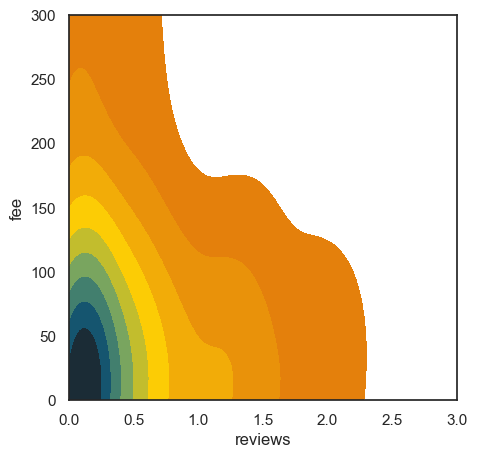

In [215]:
fig, ax = plt.subplots(figsize=(5, 5))
x='reviews'
y='fee'
cmap = load_cmap('Balistapus_undulatus', type='continuous', type_warning = False)
temp_df = df
temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

sns.set_style("white")
sns.kdeplot(x=temp_df[x], y=df[y], cmap=cmap, fill=True)
plt.ylim(0, 300)
plt.xlim(0, 3)
plt.show()

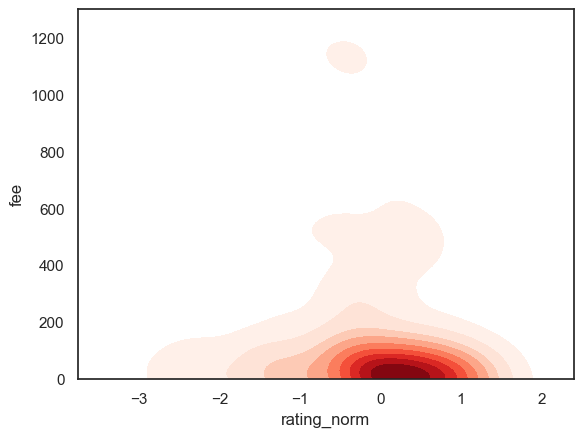

In [221]:
x='rating_norm'
y='fee'
temp_df = df
temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

sns.set_style("white")
sns.kdeplot(x=temp_df[x], y=df[y], cmap='Reds', fill=True)
plt.ylim(0, 1300)
plt.show()

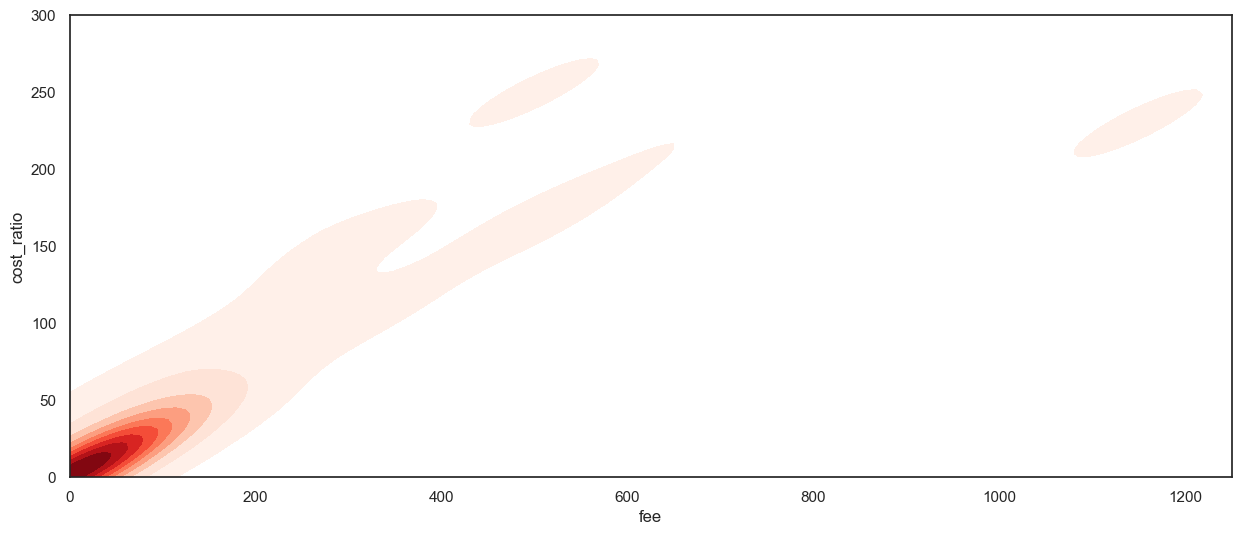

In [927]:
y='cost_ratio'
x='fee'
temp_df = df
temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

sns.set_style("white")
sns.kdeplot(x=temp_df[x], y=df[y], cmap='Reds', fill=True)
plt.ylim(0, 300)
plt.xlim(0, 1250)
plt.show()

## Categorical Analysis

In [740]:
def cat_hist(x, df=df):
    """
    Create bar chart showing count of each type within variable x.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of count.
    
    """
    #filter dataframe on elements with count greater than 3
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)

    #create figure
    fig = px.histogram(temp_df, x=x).update_xaxes(categoryorder="total descending")

    return fig


def cat_bar(x, y, df=df):
    """
    Create bar chart showing average value of each type y within variable x.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the numerical element for bar value.
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of average y-value.
    
    """
    #filter dataframe on elements with count greater than 3. Compute mean y value of each type.
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    x, observed = False)[[y]].mean().sort_values(y, ascending = False).dropna()

    #create figure
    fig = px.bar(temp_df, y=y)

    #plot settings
    fig.update_layout(
        title="Average rating for each "+ x + " category",
        xaxis_title="",
        yaxis_title=y,)

    return fig        


def categorical(x, y, df=df):
    """
    Produce bar chart of counts.
    Produce bar chart of average y value.
    Display ANOVA stats
    Display t-test dataframe.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y ; string
        The name of the numerical element to compute tests.
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of counts.
    Bar chart of average y value.
    ANOVA stats
    t-test dataframe
    
    """

    cat_hist(x, df=df).show()
    
    cat_bar(x, y, df=df).show()
    
    print(pg.anova(data=df, dv=y, between=x))

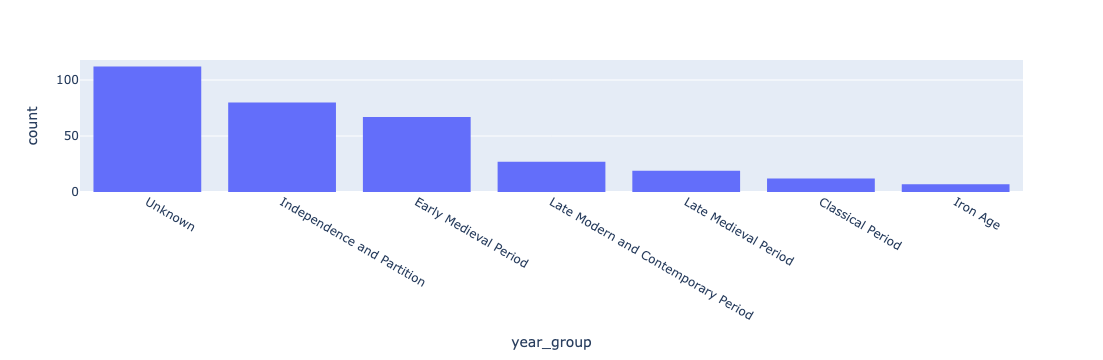

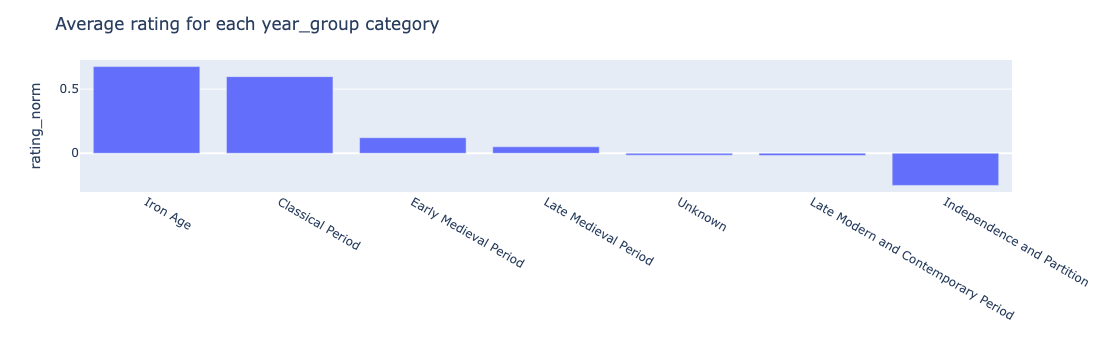

       Source  ddof1  ddof2         F     p-unc       np2
0  year_group      7    317  2.172245  0.036403  0.045772


In [742]:
categorical('year_group', 'rating_norm')

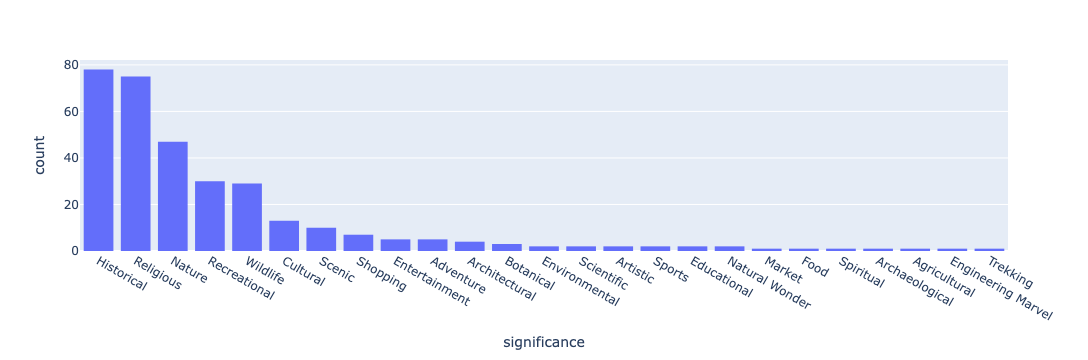

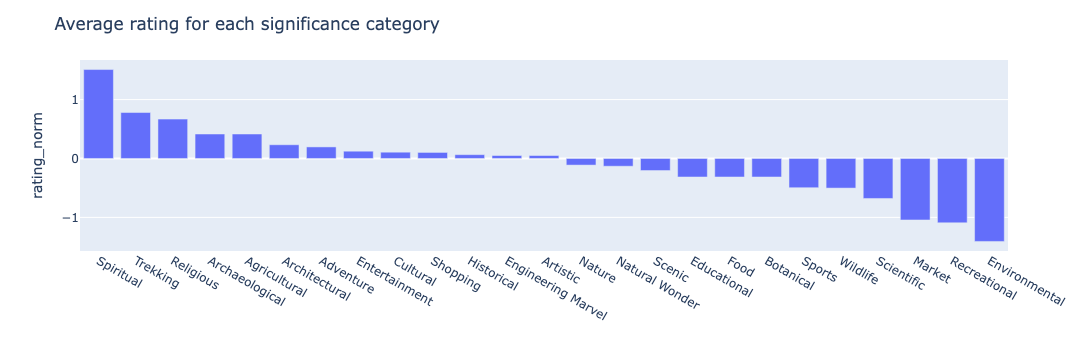

         Source  ddof1  ddof2         F         p-unc       np2
0  significance     24    300  4.714182  3.796962e-11  0.273855


In [732]:
categorical('significance', 'rating_norm')

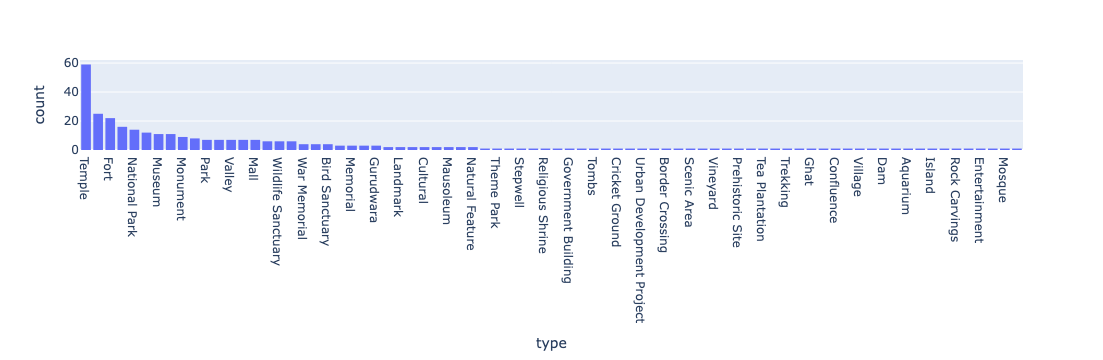

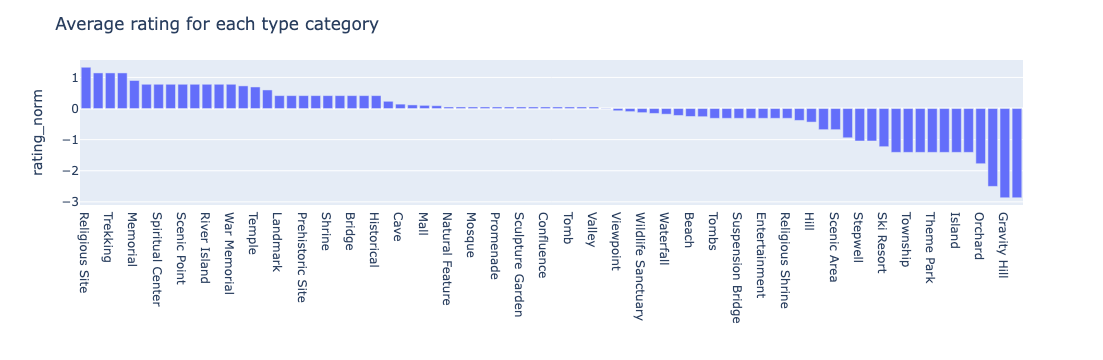

  Source  ddof1  ddof2         F         p-unc       np2
0   type     77    247  2.557954  2.177626e-08  0.443647


In [734]:
categorical('type', 'rating_norm')

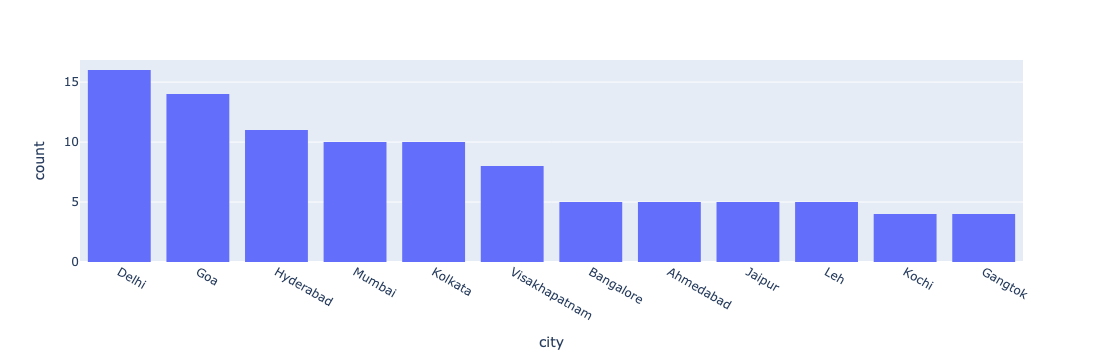

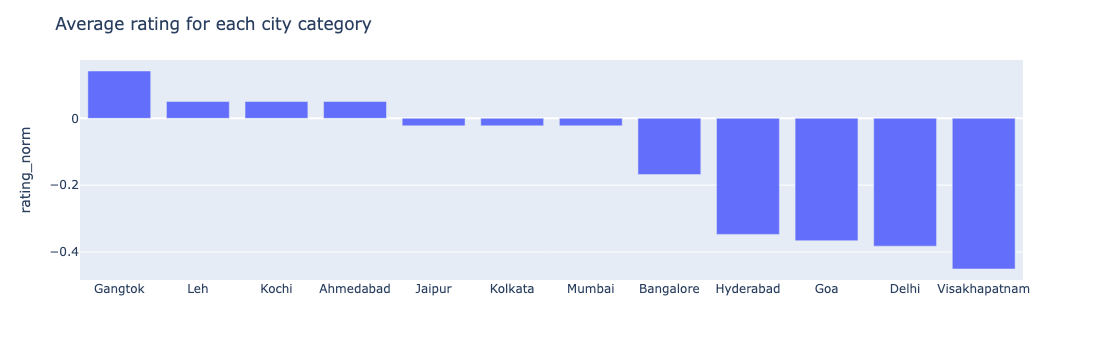

  Source  ddof1  ddof2         F     p-unc       np2
0   city    213    111  0.878711  0.788786  0.627723


category   p-value
0    Delhi  0.047074

In [685]:
categorical('city', 'rating_norm')

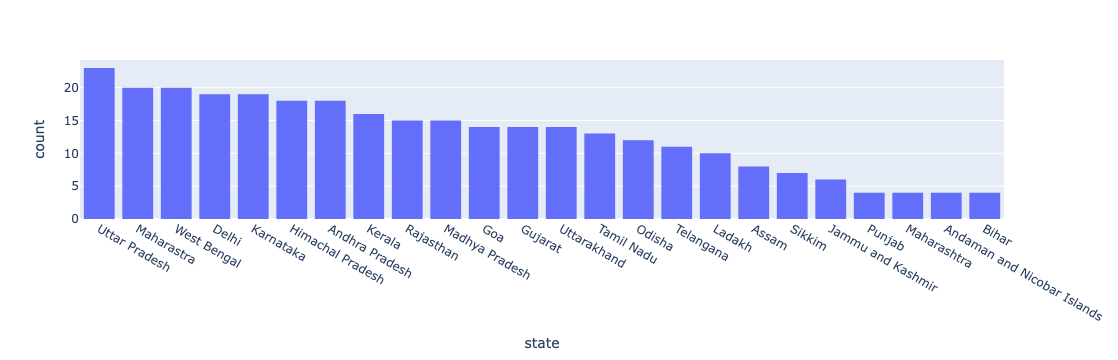

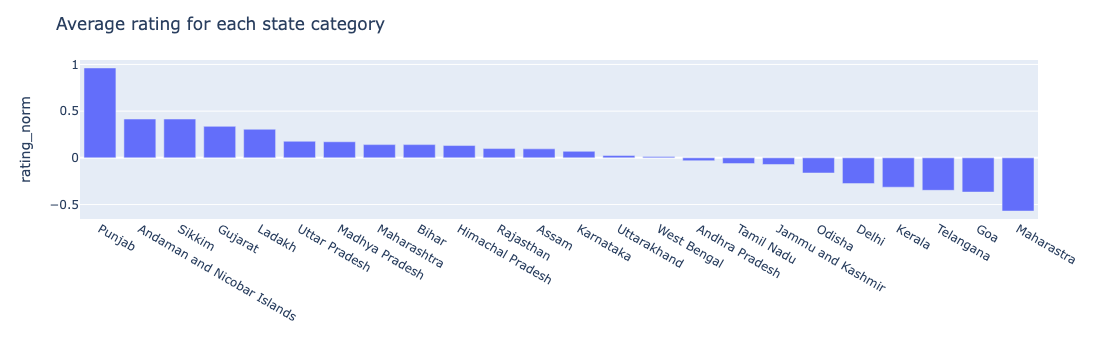

  Source  ddof1  ddof2         F     p-unc       np2
0  state     32    292  0.808365  0.761932  0.081379


In [597]:
categorical('state', 'rating_norm')

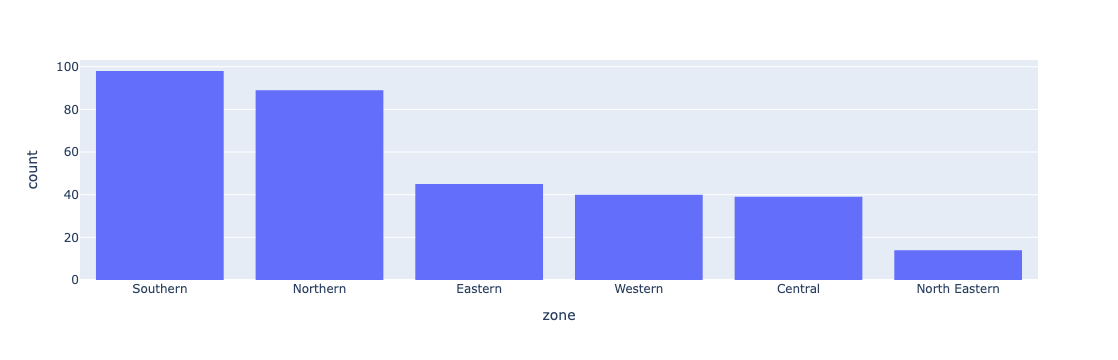

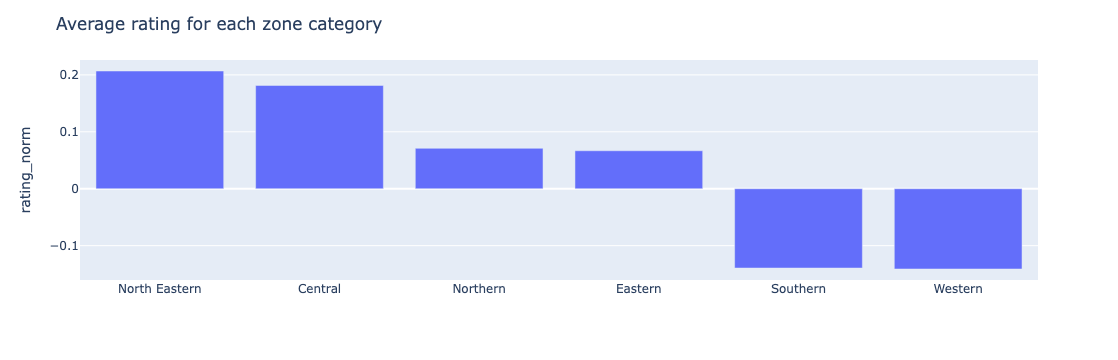

  Source  ddof1  ddof2         F    p-unc       np2
0   zone      5    319  1.043268  0.39215  0.016089


In [689]:
categorical('zone', 'rating_norm')

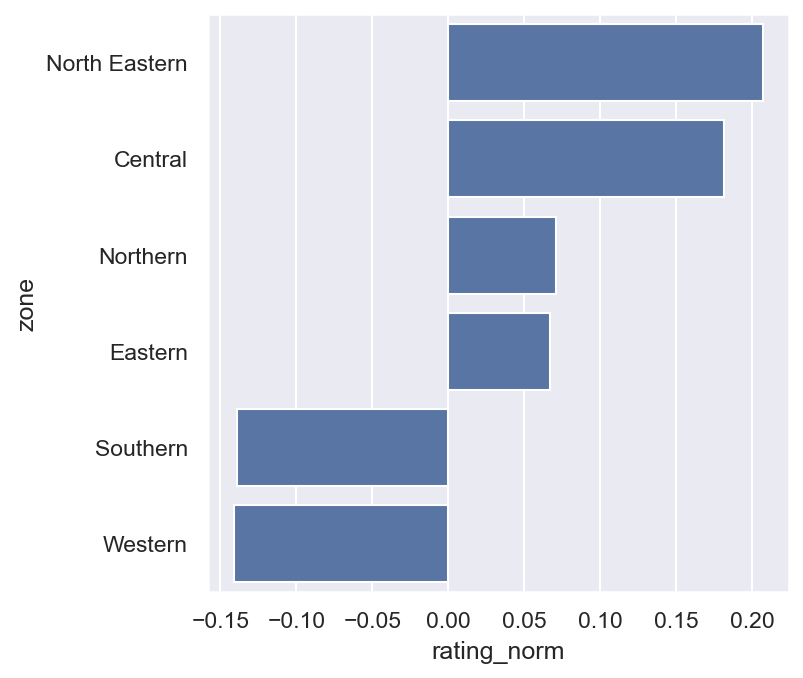

In [2239]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
x = 'zone'
# load dataset
#temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).sort_values('rating_norm', ascending = False)

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x]).mean('rating_norm').sort_values('rating_norm', ascending = False)

# Set the figure size
plt.figure(figsize=(5, 5))

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h');

In [253]:
df.sort_values('rating', ascending = False)

zone             state           city  \
196  Northern            Ladakh            Leh   
72    Western           Gujarat  Rann Of Kutch   
92   Northern            Punjab       Amritsar   
94   Northern            Punjab       Amritsar   
207  Northern            Ladakh           Dras   
..        ...               ...            ...   
167  Northern  Himachal Pradesh          Kufri   
264  Southern    Andhra Pradesh  Visakhapatnam   
103  Southern            Kerala      Kumarakom   
208  Northern            Ladakh            Leh   
26    Western        Maharastra       Lonavala   

                                name             type     year  time  rating  \
196                      Pangong Tso             Lake  Unknown   2.0     4.9   
72                        Rann Utsav         Cultural  Unknown   3.0     4.9   
92   Golden Temple (Harmandir Sahib)   Religious Site     1604   1.5     4.9   
94                      Wagah Border  Border Crossing     1950   2.0     4.8   
207                Dras War Memorial     War Memorial  Unknown   1.0     4.8   
..                               ...              ...      ...   ...     ...   
167                  Kufri Fun World       Ski Resort     1975   5.0     3.8   
264          Matsyadarshini Aquarium         Aquarium  Unknown   1.0     3.8   
103         Kumarakom Bird Sanctuary   Bird Sanctuary     1972   2.0     3.8   
208                    Magnetic Hill     Gravity Hill  Unknown   0.5     3.7   
26                          Imagicaa   Amusement Park     2013   5.0     1.4   

      fee airport  ... camera_num airport_num anytime  year_num  \
196    20     Yes  ...          1           1   False       NaN   
72   7500     Yes  ...          1           1   False       NaN   
92      0     Yes  ...          1           1   False    1604.0   
94      0     Yes  ...          1           1   False    1950.0   
207     0      No  ...          1           0   False       NaN   
..    ...     ...  ...        ...         ...     ...       ...   
167  1500     Yes  ...          1           1   False    1975.0   
264    20     Yes  ...          1           1   False       NaN   
103    50     Yes  ...          1           1   False    1972.0   
208     0     Yes  ...          1           1   False       NaN   
26   1149      No  ...          1           0   False    2013.0   

                     year_group  cost_ratio  rating_norm   fee_log  \
196                     Unknown        10.0     1.509522  3.044522   
72                      Unknown      2500.0     1.509522  8.922792   
92        Early Medieval Period         0.0     1.509522  0.000000   
94   Independence and Partition         0.0     1.144767  0.000000   
207                     Unknown         0.0     1.144767  0.000000   
..                          ...         ...          ...       ...   
167  Independence and Partition       300.0    -2.502776  7.313887   
264                     Unknown        20.0    -2.502776  3.044522   
103  Independence and Partition        25.0    -2.502776  3.931826   
208                     Unknown         0.0    -2.867530  0.000000   
26   Independence and Partition       229.8   -11.256880  7.047517   

     reviews_log cost_ratio_log  
196     0.139762       2.397895  
72      0.095310       7.824446  
92      1.064711       0.000000  
94      0.157004       0.000000  
207     0.011929       0.000000  
..           ...            ...  
167     0.095310       5.707110  
264     0.029559       3.044522  
103     0.095310       3.258097  
208     0.095310       0.000000  
26      0.667829       5.441552  

[325 rows x 25 columns]

In [270]:
def filter_locations(df, center_lat, center_lon, max_distance):
    """
    Filters a dataframe based on distance from a center point.

    Args:
        df: The dataframe containing latitude and longitude columns.
        center_lat: Latitude of the center point.
        center_lon: Longitude of the center point.
        max_distance: Maximum distance in kilometers.

    Returns:
        Filtered dataframe.
    """

    def calculate_distance(row):
        coords_1 = (center_lat, center_lon)
        coords_2 = (row['lat'], row['lon'])
        return geodesic(coords_1, coords_2).km

    df['distance'] = df.apply(calculate_distance, axis=1)
    return df[df['distance'] <= max_distance]

In [288]:
def calculate_circumcenter(x1, y1, x2, y2, x3, y3):
    """
    Calculates the circumcenter of a triangle formed by three points.
    The circumcenter is the point that is equidistant from all three vertices.
    """

    # Calculate the midpoints of two sides of the triangle
    midpoint1_x = (x1 + x2) / 2
    midpoint1_y = (y1 + y2) / 2
    midpoint2_x = (x2 + x3) / 2
    midpoint2_y = (y2 + y3) / 2

    # Calculate the slopes of the two sides
    slope1 = (y2 - y1) / (x2 - x1) if x2 != x1 else float('inf')
    slope2 = (y3 - y2) / (x3 - x2) if x3 != x2 else float('inf')

    # Calculate the perpendicular bisector slopes
    perp_slope1 = -1 / slope1 if slope1 != 0 else float('inf')
    perp_slope2 = -1 / slope2 if slope2 != 0 else float('inf')

    # Calculate the intersection of the perpendicular bisectors, which is the circumcenter
    if perp_slope1 == float('inf'):
        circumcenter_x = midpoint1_x
        circumcenter_y = perp_slope2 * (circumcenter_x - midpoint2_x) + midpoint2_y
    elif perp_slope2 == float('inf'):
        circumcenter_x = midpoint2_x
        circumcenter_y = perp_slope1 * (circumcenter_x - midpoint1_x) + midpoint1_y
    else:
        circumcenter_x = (midpoint2_y - midpoint1_y + perp_slope1 * midpoint1_x - perp_slope2 * midpoint2_x) / (perp_slope1 - perp_slope2)
        circumcenter_y = perp_slope1 * (circumcenter_x - midpoint1_x) + midpoint1_y

    return circumcenter_x, circumcenter_y


geolocator = Nominatim(user_agent="my_geocoder")
D_location = geolocator.geocode('Delhi')
A_location = geolocator.geocode('Agra')
J_location = geolocator.geocode('Jaipur')

# Example usage
x1, y1 = D_location.latitude, D_location.longitude
x2, y2 = A_location.latitude, A_location.longitude
x3, y3 = J_location.latitude, J_location.longitude

circumcenter_x, circumcenter_y = calculate_circumcenter(x1, y1, x2, y2, x3, y3)

print(f"The point equidistant from the three locations is: ({circumcenter_x}, {circumcenter_y})")

The point equidistant from the three locations is: (27.481130245530522, 76.8627231273416)


In [284]:
location[1]

(28.6273928, 77.1716954)

In [804]:
temp_df

city        lat        lon    distance
0             Delhi  28.627393  77.171695  130.610322
79           Jaipur  26.915458  75.818982  120.925928
181            Agra  27.175255  78.009816  118.473285
184         Mathura  27.495554  77.685555   81.329938
186       Vrindavan  27.575373  77.693804   82.761305
190  Fatehpur Sikri  27.091165  77.662398   90.194243
191           Noida  28.570633  77.327215  129.089547
192         Aligarh  27.876107  78.135815  133.000569
302        Gurugram  28.464615  77.029919  110.223158
305       New Delhi  28.643086  77.219267  133.453201
308   Greater Noida  28.467073  77.513765  126.651556

In [802]:
temp_df = df_geo[['city','lat','lon']].drop_duplicates()
# city = 'Delhi'

# city_lat = temp_df[temp_df['city'] == city].loc[0,'lat']
# city_lon = temp_df[temp_df['city'] == city].loc[0,'lon']

temp_df = filter_locations(temp_df.dropna(), circumcenter_x, circumcenter_y, 150)

temp_df = df[df['city'].isin(temp_df['city'])]

#temp_df = temp_df[temp_df['year_num'] < 1800]

# x = 'type'
# y= 'rating_norm'


# filter_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
#     x, observed = False)[[y]].mean().sort_values(y, ascending = False).dropna().head().index

# temp_df = temp_df[temp_df['type'].isin(filter_df)]

# temp_df = temp_df[temp_df['significance'] == 'Religious']

#print(temp_df.mean(numeric_only = True))

#temp_df[temp_df['camera'] == 'No'].mean(numeric_only = True)

# display(temp_df.sort_values('rating', ascending = False))

#univariate('rating_norm', temp_df)

# temp_df.describe()


print(temp_df[temp_df['rating_norm'] > 0].shape[0]/temp_df.shape[0])

print(temp_df[temp_df['rating_norm'] > 0].shape[0])

#temp_df[temp_df['rating_norm'] > 0].sort_values('rating', ascending = False)

temp_df[temp_df['rating_norm'] > 0].sort_values('reviews', ascending = False)


/var/folders/ch/vtrzxzd54fnd86qrm9lwcl680000gn/T/ipykernel_1519/3341810448.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyError: 'city'

In [798]:
temp_df = df_geo[['city','lat','lon']].drop_duplicates()
r = 250

temp_df['lat'].max()-temp_df['lat'].min()

temp_df['lon'].max()-temp_df['lon'].min()


lat_min = temp_df['lat'].min()
lat_lst = []
i = 0

    
    


temp_df['lat'].iloc[2]

temp_df['lat'].min()

8.079252

In [812]:
def coord_grid(lat_min = df_geo['lat'].min(), lat_max = df_geo['lat'].max(),
               lon_min = df_geo['lon'].min(), lon_max = df_geo['lon'].max(), r = 150, df = df_geo):
    


    temp_df = df[['city','lat','lon']].drop_duplicates()
    r = r
    
    # Define the grid dimensions
    x_min, x_max = lat_min, lat_max
    y_min, y_max = lon_min, lon_max
    step = 0.01 * r
    
    # Create the coordinate arrays
    x = np.arange(x_min, x_max + step, step)
    y = np.arange(y_min, y_max + step, step)
    
    # Create the meshgrid
    xx, yy = np.meshgrid(x, y)
    
    # Create the dataframe
    coord_grid_df = pd.DataFrame({'x': xx.ravel(), 'y': yy.ravel()})
    
    return coord_grid_df

In [2030]:
temp_df = df_geo[['city','lat','lon']].drop_duplicates()
r = 150
i = 41
j = 41
x_lst = []
y_lst = []
avg_lst = []
new_df = pd.DataFrame()

In [938]:
cg_df = coord_grid(r=r).sort_values('x')

cg_df['y'].iloc[41]
#cg_df['x'].iloc[41]

71.9662602

In [2106]:
range(0, coord_grid().shape[0]-1)

range(0, 360)

In [2112]:
temp_df = filter_locations(temp_df.dropna(), x, y, r)

ValueError: Cannot set a DataFrame with multiple columns to the single column distance

In [2098]:
i = 360

In [2230]:
temp_df = df_geo[['city','lat','lon']].drop_duplicates()
temp_df

city        lat        lon
0                 Delhi  28.627393  77.171695
16               Mumbai  19.081577  72.886628
26             Lonavala  18.750369  73.406944
27            Bangalore  12.988157  77.622600
32            Hyderabad  17.360589  78.474061
42              Kolkata  22.572646  88.363895
52                  Goa  15.300454  74.085513
66            Ahmedabad  23.021537  72.580057
67               Dwarka  22.240801  68.966260
68             Junagadh  21.522042  70.458246
69                 Bhuj  23.247245  69.668339
70             Vadodara  22.297314  73.194257
71              Somnath  20.895717  70.408047
72        Rann Of Kutch  23.790552  70.496614
73              Kevadia  21.294772  73.147244
74          Gandhinagar  23.223288  72.649227
79               Jaipur  26.915458  75.818982
80              Udaipur  24.578721  73.686257
81            Jaisalmer  26.911662  70.912489
82       Sawai Madhopur  26.113718  76.424064
83              Pushkar  26.487647  74.557848
84                Ajmer  26.469100  74.639000
85              Jodhpur  26.296772  73.035143
86          Chittorgarh  24.717158  74.471813
87            Mount Abu  24.592433  72.708188
88              Bikaner  28.015929  73.317137
92             Amritsar  31.635666  74.878750
95           Chandigarh  30.733442  76.779714
96            Alappuzha   9.500665  76.412414
97               Munnar  10.086996  77.060091
98                Kochi   9.967428  76.245444
99   Thiruvananthapuram   8.488227  76.947551
100           Kozhikode  11.245056  75.775472
101             Wayanad  11.715129  76.127119
102            Thekkady   9.580500  77.181142
103           Kumarakom   9.594995  76.430260
104             Varkala   8.734229  76.725709
105               Bekal  12.395725  75.037192
106             Kovalam   8.390259  76.978515
107              Kannur  11.876384  75.373797
108       Nelliyampathy  10.534924  76.693249
111              Mysore  12.305183  76.655361
112               Hampi  15.335800  76.461020
113               Coorg  12.936334  77.615118
114             Gokarna  14.543963  74.318442
115         Chikmagalur  13.318014  75.773874
116              Badami  15.920387  75.680786
117          Shivamogga  13.932609  75.574978
118           Mangalore  12.869810  74.843008
119         Murudeshwar  15.341086  75.119711
120             Bijapur  18.793568  80.815939
121            Bandipur  27.938022  84.406696
122            Halebidu  12.592395  76.691347
123                Pune  18.521374  73.854507
124          Aurangabad  24.803320  84.411020
125              Nashik  20.011247  73.790236
126              Shirdi  19.766812  74.475439
127             Alibaug  18.662743  72.878773
128           Ratnagiri  17.282608  73.456979
129              Nagpur  21.149813  79.082056
130            Kolhapur  16.702841  74.240533
132            Tarkarli  16.006814  73.491840
133              Satara  17.636129  74.298278
134            Matheran  18.990154  73.270019
135              Ajanta  20.532524  75.751369
136           Khajuraho  24.851513  79.925979
137              Bhopal  23.258486  77.401989
138              Indore  22.720362  75.868200
139             Gwalior  26.203725  78.157363
140              Ujjain  23.188513  75.771656
141            Jabalpur  23.170152  79.932451
142           Pachmarhi  22.473682  78.436054
143               Kanha  22.276984  80.627865
144         Bandhavgarh  23.644413  81.024502
145              Orchha  25.352871  78.640247
146               Mandu  23.797852  85.526332
147           Bhimbetka  22.938401  77.613329
148          Amarkantak  22.670465  81.758842
149          Chitrakoot  25.217139  81.104593
150              Shimla  31.104153  77.170973
151              Manali  32.245461  77.187293
152           Dalhousie  32.530000  75.980000
154        Spiti Valley        NaN        NaN
155               Kullu  31.957897  77.108923
156              Chamba  32.692332  76.163155
157             Kinnaur  31.593013  78.328142
158              

In [2240]:

cg_df = coord_grid(r=r).sort_values('x')
r = 150
i = 0
x_lst = []
y_lst = []
avg_lst = []

#j = 41

for i in range(0, coord_grid().shape[0]-1):
    
    temp_df = df_geo[['city','lat','lon']].drop_duplicates()
    x, y = coord_grid().sort_values('x').iloc[i]
    
    temp_df = filter_locations(temp_df.dropna(), x, y, r)
    
    temp_df = df[df['city'].isin(temp_df['city'])]
    
    if not temp_df.empty:
        avg_lst.append(temp_df['rating_norm'].mean())
        x_lst.append(x)
        y_lst.append(y)
        

# display(temp_df)
# print(cg_df['x'].iloc[i], cg_df['x'].iloc[j])

# print(x_lst)
# print(y_lst)
# print(avg_lst)

/var/folders/ch/vtrzxzd54fnd86qrm9lwcl680000gn/T/ipykernel_1519/3341810448.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ch/vtrzxzd54fnd86qrm9lwcl680000gn/T/ipykernel_1519/3341810448.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ch/vtrzxzd54fnd86qrm9lwcl680000gn/T/ipykernel_1519/3341810448.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [2250]:

cg_df = coord_grid(r=r).sort_values('x')
r = 150
i = 0
x_lst = []
y_lst = []
ct_lst = []

#j = 41

for i in range(0, coord_grid().shape[0]-1):
    
    temp_df = df_geo[['city','lat','lon']].drop_duplicates()
    x, y = coord_grid().sort_values('x').iloc[i]
    
    temp_df = filter_locations(temp_df.dropna(), x, y, r)
    
    temp_df = df[df['city'].isin(temp_df['city'])]

    temp_df = temp_df[temp_df['rating_norm'] > 0]
    
    if not temp_df.empty:
        ct_lst.append(temp_df['rating_norm'].count())
        x_lst.append(x)
        y_lst.append(y)
        

# display(temp_df)
# print(cg_df['x'].iloc[i], cg_df['x'].iloc[j])

# print(x_lst)
# print(y_lst)
# print(avg_lst)

/var/folders/ch/vtrzxzd54fnd86qrm9lwcl680000gn/T/ipykernel_1519/3341810448.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ch/vtrzxzd54fnd86qrm9lwcl680000gn/T/ipykernel_1519/3341810448.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ch/vtrzxzd54fnd86qrm9lwcl680000gn/T/ipykernel_1519/3341810448.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [2220]:
len(df[df['rating_norm'] > 0])

211

In [2140]:
len(x_lst)
#len(y_lst)
#len(avg_lst)

162

In [2252]:
temp_df = pd.DataFrame({'lat':x_lst, 'lon':y_lst, 'count':ct_lst})

temp_df.sort_values('count', ascending = False)

lat       lon  count
120  27.579252  76.46626     22
127  27.579252  77.96626     21
131  29.079252  77.96626     18
129  29.079252  76.46626     16
144  33.579252  76.46626     13
24   15.579252  74.96626     11
135  30.579252  77.96626     11
139  32.079252  76.46626     11
140  32.079252  77.96626     10
29   15.579252  73.46626     10
142  32.079252  74.96626      8
14   12.579252  76.46626      8
82   23.079252  88.46626      8
114  26.079252  88.46626      8
133  30.579252  79.46626      8
40   18.579252  82.46626      7
20   14.079252  77.96626      7
48   20.079252  71.96626      7
46   20.079252  73.46626      7
118  27.579252  88.46626      7
148  35.079252  76.46626      7
42   18.579252  73.46626      6
146  33.579252  77.96626      6
4     9.579252  76.46626      6
58   21.579252  88.46626      6
39   18.579252  83.96626      6
18   12.579252  77.96626      6
36   17.079252  83.96626      6
11   11.079252  76.46626      6
149  35.079252  77.96626      6
84   23.079252  71.96626      5
19   14.079252  74.96626      5
145  33.579252  74.96626      5
34   17.079252  82.46626      5
64   21.579252  70.46626      5
105  26.079252  74.96626      5
44   18.579252  71.96626      5
81   23.079252  73.46626      5
98   24.579252  85.46626      5
30   17.079252  79.46626      5
21   14.079252  76.46626      5
147  35.079252  74.96626      5
25   15.579252  76.46626      4
125  27.579252  86.96626      4
9    11.079252  79.46626      4
141  32.079252  73.46626      4
89   24.579252  91.46626      4
32   17.079252  77.96626      4
117  27.579252  74.96626      4
115  27.579252  89.96626      4
112  26.079252  77.96626      4
109  26.079252  76.46626      4
108  26.079252  82.46626      4
97   24.579252  83.96626      4
76   23.079252  76.46626      4
80   23.079252  77.96626      4
51   20.079252  86.96626      4
113  26.079252  94.46626      4
107  26.079252  83.96626      4
59   21.579252  85.46626      4
54   20.079252  85.46626      4
104  26.079252  91.46626      4
101  26.079252  92.96626      4
137  30.579252  76.46626      4
134  30.579252  80.96626      3
136  30.579252  74.96626      3
138  32.079252  79.46626      3
13   12.579252  74.96626      3
6     9.579252  79.46626      3
7    11.079252  80.96626      3
8    11.079252  77.96626      3
2     8.079252  76.46626      3
68   21.579252  71.96626      3
69   21.579252  79.46626      3
70   23.079252  91.46626      3
71   23.079252  85.46626      3
75   23.079252  80.96626      3
92   24.579252  86.96626      3
95   24.579252  80.96626      3
63   21.579252  77.96626      3
110  26.079252  79.46626      3
111  26.079252  80.96626      3
96   24.579252  82.46626      3
77   23.079252  86.96626      3
121  27.579252  92.96626      3
50   20.079252  70.46626      3
41   18.579252  77.96626      3
116  27.579252  91.46626      3
31   17.079252  73.46626      3
17   12.579252  92.96626      3
83   23.079252  79.46626      3
86   24.579252  73.46626      3
10   11.079252  92.96626      3
1     8.079252  77.96626      3
5     9.579252  77.96626      2
87   24.579252  92.96626      2
78   23.079252  70.46626      2
88   24.579252  74.96626      2
72   23.079252  83.96626      2
94   24.579252  79.46626      2
93   24.579252  88.46626      2
79   23.079252  68.96626      2
65   21.579252  68.96626      2
62   21.579252  86.96626      2
106  26.079252  89.96626      2
102  26.079252  73.46626      2
61   21.579252  76.46626      2
26   15.579252  77.96626      2
12   11.079252  74.96626      2
3     9.579252  74.96626      2
35   17.079252  74.96626      2
49   20.079252  80.96626      2
123  27.579252  94.46626      2
37   18.579252  80.96626      2
28   15.579252  79.46626      2
122  27.579252  73.46626      2
56   20.079252  74.96626      2
57   21.579252  83.96626      2
15   12.579252  79.46626      2
0     8.079252  79.46626      2
103  26.079252  85.46626      1
60   21.579252  74.96626      1
66   21.579252  73.46626      1
73   23.079252  74.96626      1
74   23.079

In [2104]:
i

361

In [1833]:
print(cg_df['x'].iloc[i], cg_df['x'].iloc[j], i, j)
i = i+1
j = j+1

20.079252 20.079252 162 162


In [1918]:
coord_grid().sort_values('x').iloc[0]

x     8.079252
y    68.966260
Name: 0, dtype: float64

In [916]:
pd.set_option('display.max_rows', None)
coord_grid().sort_values('x')

x         y
0     8.079252  68.96626
57    8.079252  73.46626
247   8.079252  88.46626
19    8.079252  70.46626
304   8.079252  92.96626
133   8.079252  79.46626
152   8.079252  80.96626
323   8.079252  94.46626
171   8.079252  82.46626
114   8.079252  77.96626
228   8.079252  86.96626
76    8.079252  74.96626
190   8.079252  83.96626
285   8.079252  91.46626
209   8.079252  85.46626
95    8.079252  76.46626
342   8.079252  95.96626
38    8.079252  71.96626
266   8.079252  89.96626
77    9.579252  74.96626
229   9.579252  86.96626
324   9.579252  94.46626
286   9.579252  91.46626
96    9.579252  76.46626
191   9.579252  83.96626
153   9.579252  80.96626
115   9.579252  77.96626
134   9.579252  79.46626
305   9.579252  92.96626
20    9.579252  70.46626
58    9.579252  73.46626
248   9.579252  88.46626
267   9.579252  89.96626
343   9.579252  95.96626
39    9.579252  71.96626
1     9.579252  68.96626
210   9.579252  85.46626
172   9.579252  82.46626
325  11.079252  94.46626
154  11.079252  80.96626
59   11.079252  73.46626
40   11.079252  71.96626
116  11.079252  77.96626
230  11.079252  86.96626
135  11.079252  79.46626
249  11.079252  88.46626
21   11.079252  70.46626
306  11.079252  92.96626
97   11.079252  76.46626
192  11.079252  83.96626
287  11.079252  91.46626
211  11.079252  85.46626
78   11.079252  74.96626
173  11.079252  82.46626
268  11.079252  89.96626
344  11.079252  95.96626
2    11.079252  68.96626
3    12.579252  68.96626
345  12.579252  95.96626
193  12.579252  83.96626
269  12.579252  89.96626
212  12.579252  85.46626
79   12.579252  74.96626
288  12.579252  91.46626
98   12.579252  76.46626
174  12.579252  82.46626
231  12.579252  86.96626
22   12.579252  70.46626
136  12.579252  79.46626
155  12.579252  80.96626
307  12.579252  92.96626
117  12.579252  77.96626
326  12.579252  94.46626
250  12.579252  88.46626
60   12.579252  73.46626
41   12.579252  71.96626
80   14.079252  74.96626
175  14.079252  82.46626
118  14.079252  77.96626
23   14.079252  70.46626
99   14.079252  76.46626
232  14.079252  86.96626
289  14.079252  91.46626
270  14.079252  89.96626
213  14.079252  85.46626
194  14.079252  83.96626
42   14.079252  71.96626
346  14.079252  95.96626
4    14.079252  68.96626
137  14.079252  79.46626
156  14.079252  80.96626
308  14.079252  92.96626
61   14.079252  73.46626
251  14.079252  88.46626
327  14.079252  94.46626
81   15.579252  74.96626
290  15.579252  91.46626
347  15.579252  95.96626
5    15.579252  68.96626
252  15.579252  88.46626
195  15.579252  83.96626
100  15.579252  76.46626
214  15.579252  85.46626
271  15.579252  89.96626
43   15.579252  71.96626
176  15.579252  82.46626
233  15.579252  86.96626
309  15.579252  92.96626
119  15.579252  77.96626
328  15.579252  94.46626
157  15.579252  80.96626
138  15.579252  79.46626
24   15.579252  70.46626
62   15.579252  73.46626
348  17.079252  95.96626
139  17.079252  79.46626
234  17.079252  86.96626
63   17.079252  73.46626
25   17.079252  70.46626
120  17.079252  77.96626
310  17.079252  92.96626
158  17.079252  80.96626
291  17.079252  91.46626
177  17.079252  82.46626
82   17.079252  74.96626
6    17.079252  68.96626
196  17.079252  83.96626
215  17.079252  85.46626
101  17.079252  76.46626
272  17.079252  89.96626
253  17.079252  88.46626
329  17.079252  94.46626
44   17.079252  71.96626
159  18.579252  80.96626
311  18.579252  92.96626
216  18.579252  85.46626
197  18.579252  83.96626
7    18.579252  68.96626
178  18.579252  82.46626
292  18.579252  91.46626
121  18.579252  77.96626
64   18.579252  73.46626
26   18.579252  70.46626
235  18.579252  86.96626
140  18.579252  79.46626
349  18.579252  95.96626
45   18.579252  71.96626
273  18.579252  89.96626
102  18.579252  76.46626
330  18.579252  94.46626
254  18.579252  88.46626
83   18.579252  74.96626
65   20.079252  73.46626
293  20.079252  91.46626
141  20.079252  79.46626
46   20.079252  71.96626
350  20.079252  95.96626
160  20.079252  80.96626
312  20.079252  92.96626
27   20.07925

In [906]:
i, j = coord_grid().sort_values('x').iloc[41]

print(i, j)

11.079252 71.9662602


# Plots

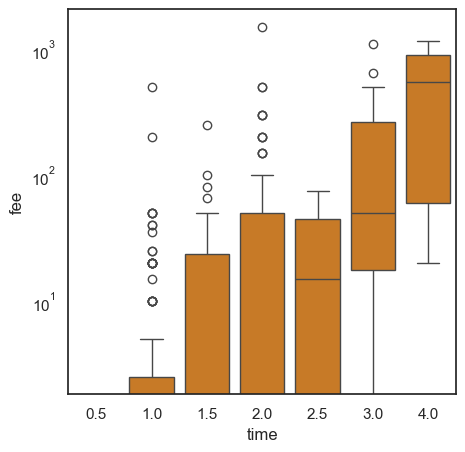

In [1353]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')

y='fee'

temp_df = df.loc[df[['time',y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
ax = sns.boxplot(x="time", y=y, data=temp_df, color = colors[0])


ax.set_yscale('log')

plt.show()

In [35]:
df.groupby('zone').describe()

time                                                rating  \
              count      mean       std  min    25%  50%  75%  max  count   
zone                                                                        
Central        39.0  1.551282  0.559545  1.0  1.000  1.5  2.0  3.0   39.0   
Eastern        45.0  1.566667  0.809040  0.5  1.000  1.5  2.0  4.0   45.0   
North Eastern  14.0  1.857143  0.744946  1.0  1.125  2.0  2.0  3.0   14.0   
Northern       89.0  2.016854  1.139302  0.5  1.000  2.0  2.0  6.0   89.0   
Southern       98.0  1.642857  0.796254  0.5  1.000  1.5  2.0  5.5   98.0   
Western        40.0  2.250000  1.265924  1.0  1.500  2.0  3.0  7.0   40.0   

                                                                fee  \
                   mean       std  min  25%   50%    75%  max count   
zone                                                                  
Central        4.535897  0.224179  3.9  4.4  4.60  4.700  4.8  39.0   
Eastern        4.504444  0.180851  3.9  4.4  4.50  4.600  4.8  45.0   
North Eastern  4.542857  0.160357  4.1  4.5  4.55  4.675  4.7  14.0   
Northern       4.505618  0.232750  3.7  4.4  4.50  4.700  4.9  89.0   
Southern       4.447959  0.223943  3.8  4.4  4.50  4.600  4.8  98.0   
Western        4.447500  0.524276  1.4  4.4  4.50  4.600  4.9  40.0   

                                                                        \
                     mean          std  min  25%   50%     75%     max   
zone                                                                     
Central         59.358974   238.918009  0.0  0.0  10.0   40.00  1500.0   
Eastern         75.222222   372.051981  0.0  0.0   0.0   30.00  2500.0   
North Eastern  120.000000   235.568053  0.0  0.0   0.0   17.50   650.0   
Northern        92.528090   329.086307  0.0  0.0   0.0   50.00  2500.0   
Southern        59.489796   180.471161  0.0  0.0   0.0   23.75  1150.0   
Western        404.825000  1298.298648  0.0  0.0   0.0  225.00  7500.0   

              reviews                                                          \
                count      mean       std   min      25%    50%      75%  max   
zone                                                                            
Central          39.0  0.506192  1.232737  0.01  0.04750  0.100  0.42500  7.4   
Eastern          45.0  0.329378  0.407478  0.01  0.07000  0.130  0.50000  1.8   
North Eastern    14.0  0.118714  0.233698  0.01  0.01375  0.036  0.06725  0.9   
Northern         89.0  0.422056  0.548911  0.01  0.05000  0.230  0.51000  2.6   
Southern         98.0  0.408153  0.514859  0.01  0.09000  0.210  0.49000  2.5   
Western          40.0  0.473875  0.630100  0.02  0.10000  0.285  0.60000  3.6   

              camera_num                                               \
                   count      mean       std  min  25%  50%  75%  max   
zone                                                                    
Central             39.0  0.820513  0.388776  0.0  1.0  1.0  1.0  1.0   
Eastern             45.0  0.777778  0.420437  0.0  1.0  1.0  1.0  1.0   
North Eastern       14.0  0.785714  0.425815  0.0  1.0  1.0  1.0  1.0   
Northern            89.0  0.865169  0.343479  0.0  1.0  1.0  1.0  1.0   
Southern            98.0  0.806122  0.397367  0.0  1.0  1.0  1.0  1.0   
Western             40.0  0.775000  0.422902  0.0  1.0  1.0  1.0  1.0   

              airport_num                                                \
                    count      mean       std  min  25%  50%   75%  max   
zone                                                                      
Central              39.0  0.717949  0.455881  0.0  0.0  1.0  1.00  1.0   
Eastern              45.0  0.800000  0.404520  0.0  1.0  1.0  1.00  1.0   
North Eastern        14.0  0.285714  0.468807  0.0  0.0  0.0  0.75  1.0   
Northern             89.0  0.629213  0.485752  0.0  0.0  1.0  1.00  1.0   
Southern             98.0  0.755102  0.432238  0.0  1.0  1.0  1.00  1.0   
Western              40.0 

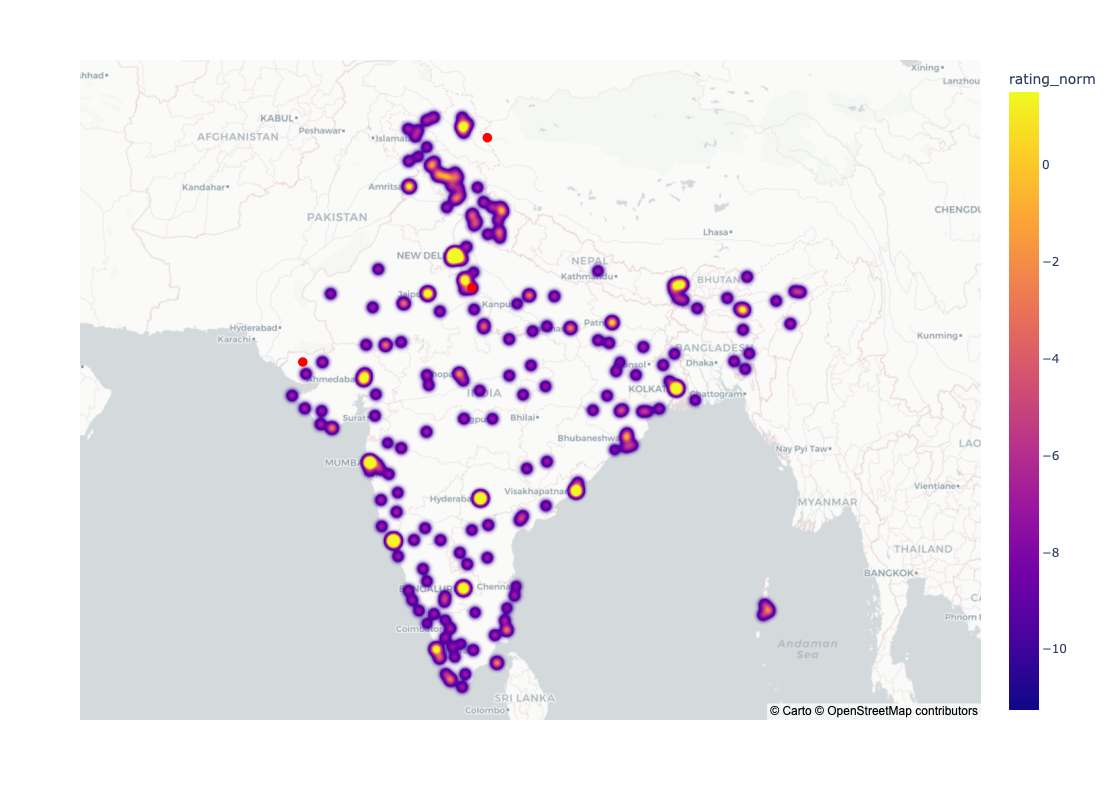

In [660]:
# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='rating_norm',
                        radius=10, center=dict(lat=22.5, lon=81),
                        zoom=3.8, mapbox_style="carto-positron", hover_name = 'city')

fig.update_layout(width = 800, height = 800)

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Taj Mahal')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Pangong Tso')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Rann Utsav')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False))

fig.show()

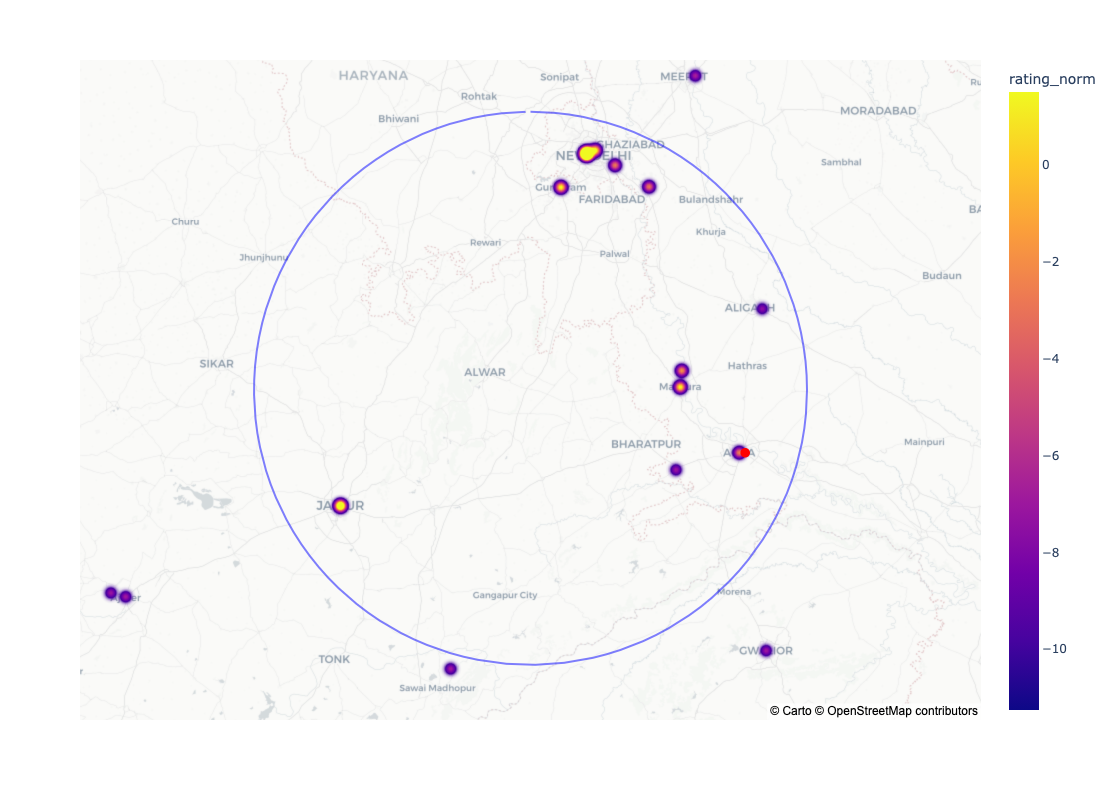

In [678]:
# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='rating_norm',
                        radius=10, center=dict(lat=circumcenter_x, lon=circumcenter_y),
                        zoom=7, mapbox_style="carto-positron", hover_name = 'city')

fig.update_layout(width = 800, height = 800)

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Taj Mahal')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Pangong Tso')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Rann Utsav')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False))

lat = circumcenter_x
lon = circumcenter_y
radius = 150
# Calculate circle coordinates
num_points = 360  # Number of points for the circle
circle_lats, circle_lons = [], []
for bearing in np.arange(0, 360, 360/num_points):
    circle_lats.append(lat + radius * np.cos(np.radians(bearing)) / 111.32)
    circle_lons.append(lon + radius * np.sin(np.radians(bearing)) / (111.32 * np.cos(np.radians(lat))))

# Add circle to the map
fig.add_trace(go.Scattermapbox(
    lat=circle_lats,
    lon=circle_lons,
    mode="lines",
    line=dict(color="blue"),
    opacity=0.5,
    hoverinfo="none", showlegend = False
))

fig.show()

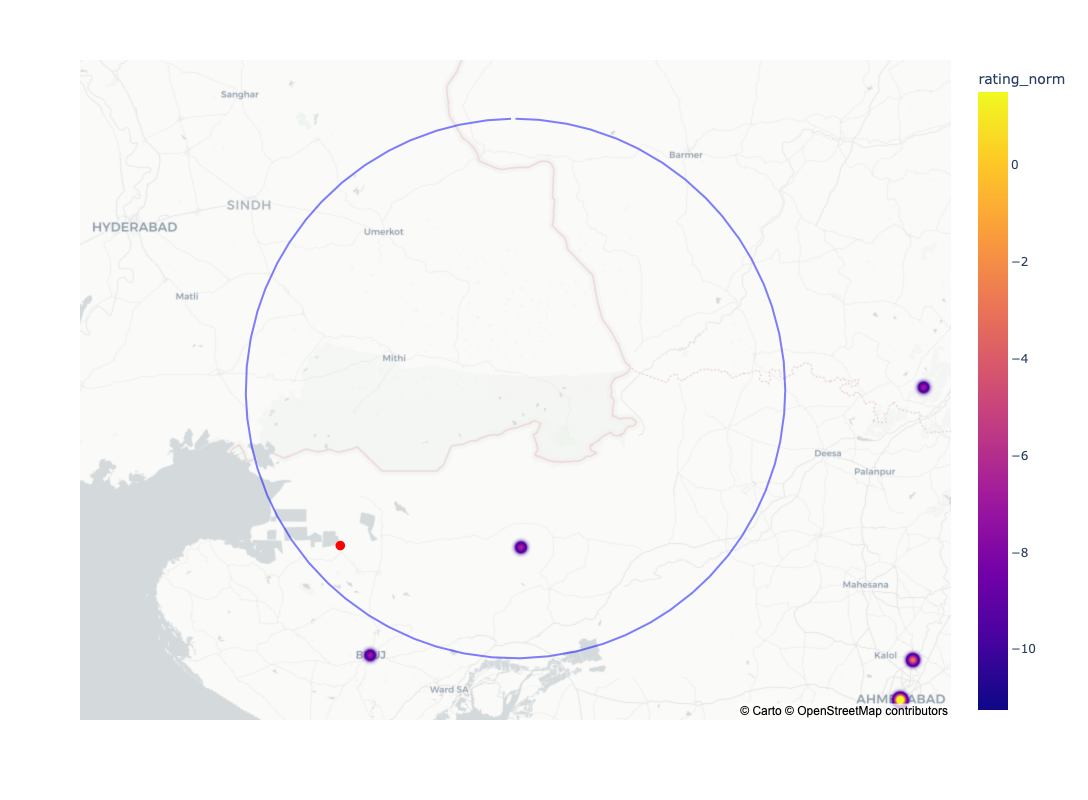

In [2154]:
# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='rating_norm',
                        radius=10, center=dict(lat=24.579252, lon=70.46626),
                        zoom=7, mapbox_style="carto-positron", hover_name = 'city')

fig.update_layout(width = 800, height = 800)

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Taj Mahal')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Pangong Tso')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Rann Utsav')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False))

lat = 24.579252
lon = 70.46626
radius = 150
# Calculate circle coordinates
num_points = 360  # Number of points for the circle
circle_lats, circle_lons = [], []
for bearing in np.arange(0, 360, 360/num_points):
    circle_lats.append(lat + radius * np.cos(np.radians(bearing)) / 111.32)
    circle_lons.append(lon + radius * np.sin(np.radians(bearing)) / (111.32 * np.cos(np.radians(lat))))

# Add circle to the map
fig.add_trace(go.Scattermapbox(
    lat=circle_lats,
    lon=circle_lons,
    mode="lines",
    line=dict(color="blue"),
    opacity=0.5,
    hoverinfo="none", showlegend = False
))

fig.show()

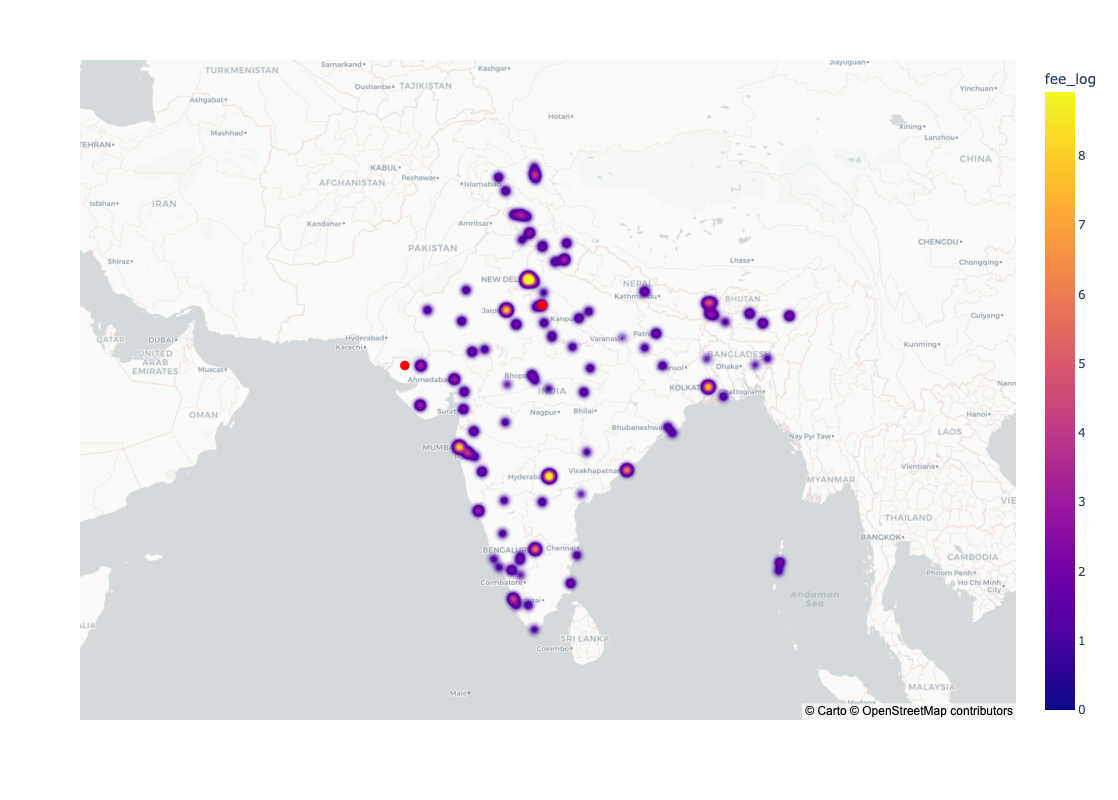

In [680]:
# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='fee_log',
                        radius=10, center=dict(lat=22.4, lon=78.4),
                        zoom=3.5, mapbox_style="carto-positron", hover_name = 'city')

fig.update_layout(width = 800, height = 800)

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Taj Mahal')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Rann Utsav')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False))

fig.show()

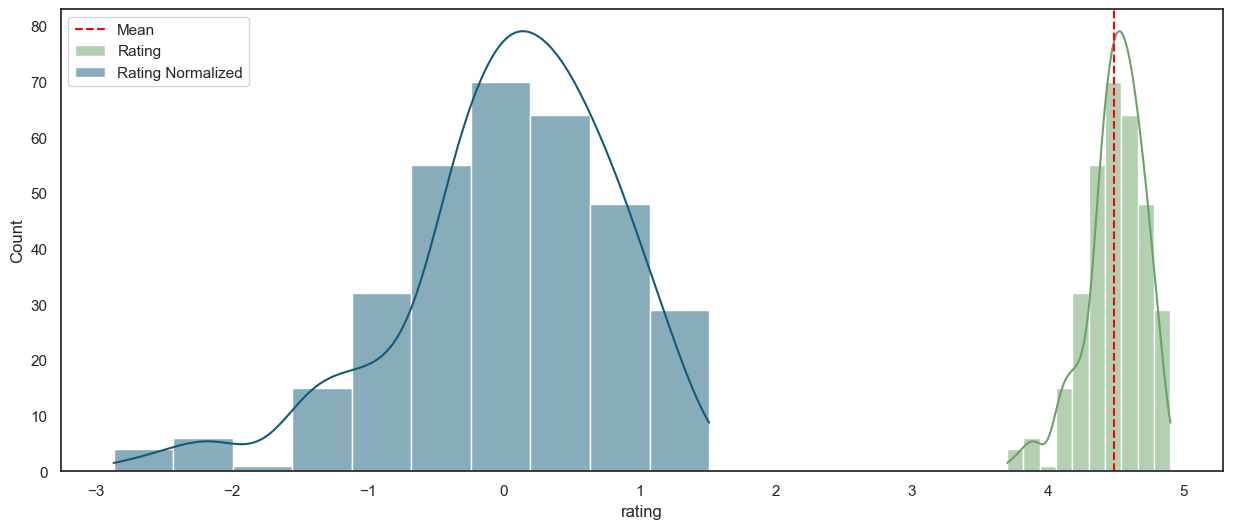

In [905]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus') 

temp_df = df.loc[df[['rating']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating", bins=10, kde=True, color=colors[2], label ='Rating')

temp_df = df.loc[df[['rating_norm']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating_norm", bins=10, kde=True, color=colors[3], label = 'Rating Normalized')

mean = np.mean(df['rating'])
plt.axvline(mean, color='red', linestyle='--', label='Mean')

plt.legend()
plt.show()

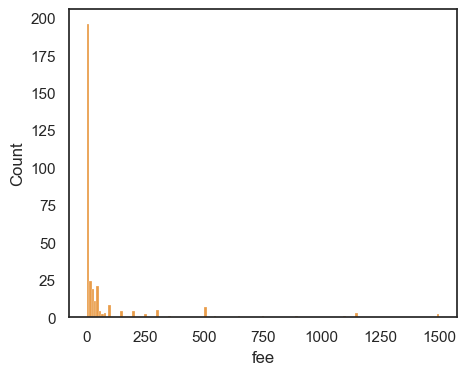

In [514]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

temp_df = df.loc[df[['fee']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]


sns.histplot(temp_df['fee'], fill=True, color=colors[0])
#sns.kdeplot(df['cost_ratio'], fill=True, color="b")
plt.show()

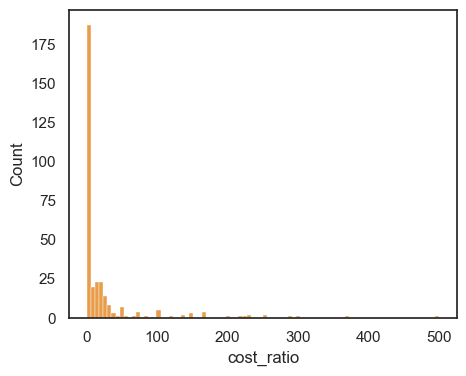

In [686]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

temp_df = df.loc[df[['cost_ratio']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]


sns.histplot(temp_df['cost_ratio'], fill=True, color=colors[0])
#sns.kdeplot(df['cost_ratio'], fill=True, color="b")
plt.show()

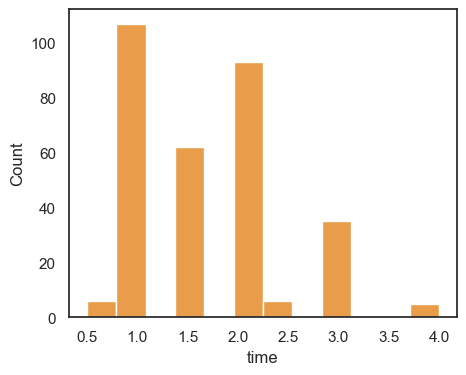

In [698]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

temp_df = df.loc[df[['time']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]


sns.histplot(temp_df['time'], fill=True, color=colors[0])
#sns.kdeplot(df['cost_ratio'], fill=True, color="b")
plt.show()

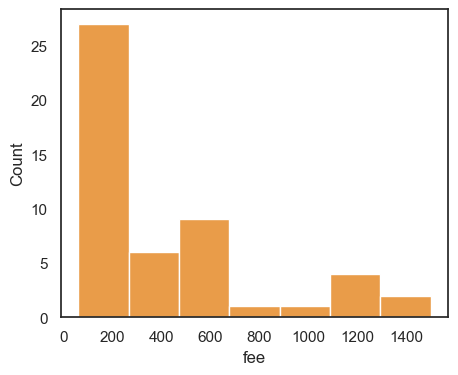

In [590]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

temp_df = df.loc[df[['fee']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

temp_df = temp_df[temp_df['fee'] > 50]


sns.histplot(temp_df['fee'], fill=True, color=colors[0])
#sns.kdeplot(df['cost_ratio'], fill=True, color="b")

#plt.ylim(0, 25)
#plt.xlim(11, 1500)
plt.show()

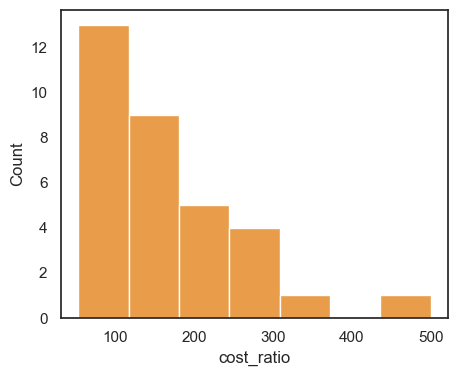

In [696]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

temp_df = df.loc[df[['cost_ratio']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

temp_df = temp_df[temp_df['cost_ratio'] > 50]


sns.histplot(temp_df['cost_ratio'], fill=True, color=colors[0])
#sns.kdeplot(df['cost_ratio'], fill=True, color="b")

#plt.ylim(0, 25)
#plt.xlim(11, 1500)
plt.show()

In [702]:
df[df['cost_ratio'] < 50].shape

(280, 25)

In [708]:
df[df['time'] < 2].shape

(175, 25)

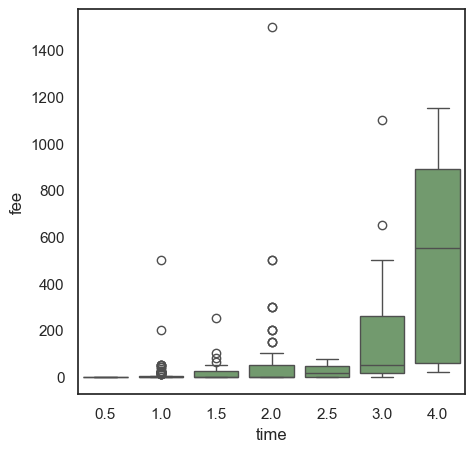

In [1439]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')

y='fee'

temp_df = df.loc[df[['time',y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
ax = sns.boxplot(x="time", y=y, data=temp_df, color = colors[2])

#ax.set_yscale('log')

plt.show()

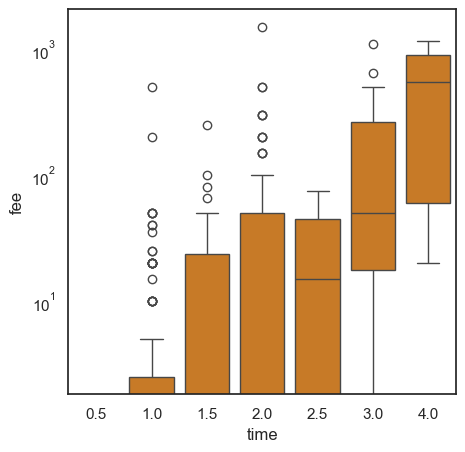

In [1353]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')

y='fee'

temp_df = df.loc[df[['time',y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
ax = sns.boxplot(x="time", y=y, data=temp_df, color = colors[0])


ax.set_yscale('log')

plt.show()

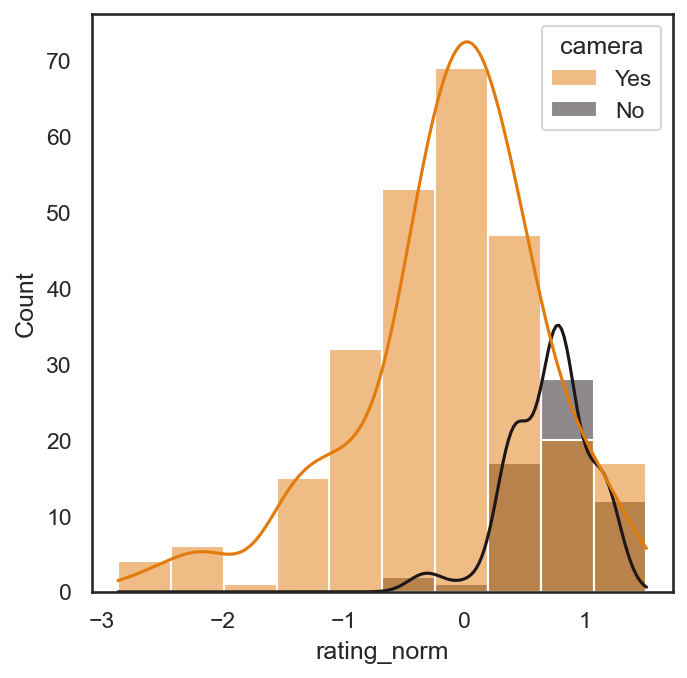

In [1473]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')


temp_df = df.loc[df[['rating_norm']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating_norm", bins=10, kde=True, hue = 'camera', palette={'Yes': colors[0], 'No': colors[4]})
plt.show()

In [1499]:
x='year_num'
y='rating_norm'
colors = get_hex('Balistapus_undulatus')

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

temp_df.loc[df['name'] == 'Taj Mahal']['year_num'].iloc[0]

1632.0

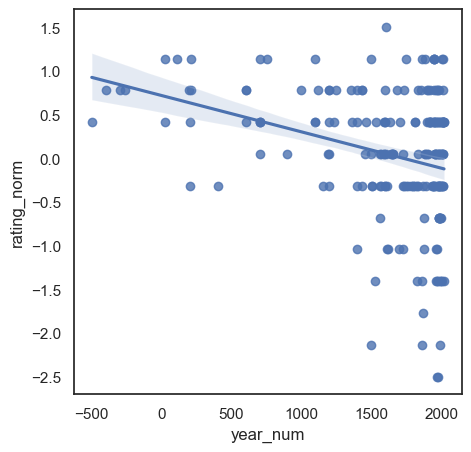

In [752]:
plt.figure(figsize=(5, 5))
x='year_num'
y='rating_norm'
colors = get_hex('Balistapus_undulatus')

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

sns.regplot(
    x=x,
    y=y,
    data=temp_df
)

plt.show()

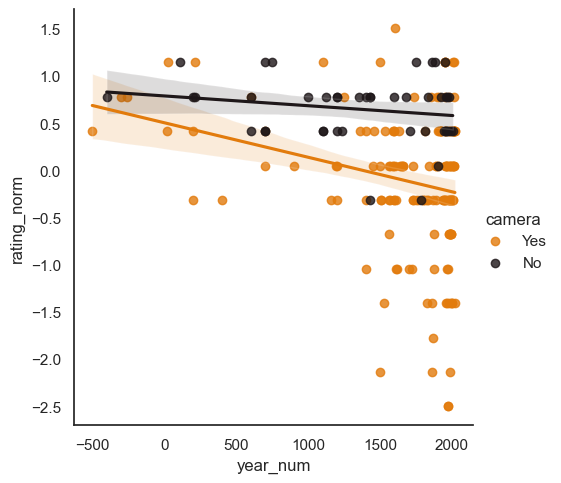

In [714]:
x='year_num'
y='rating_norm'
colors = get_hex('Balistapus_undulatus')

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.lmplot(
    x=x,
    y=y,
    data=temp_df,
    hue='camera', palette={'Yes': colors[0], 'No': colors[4]}
)

plt.show()

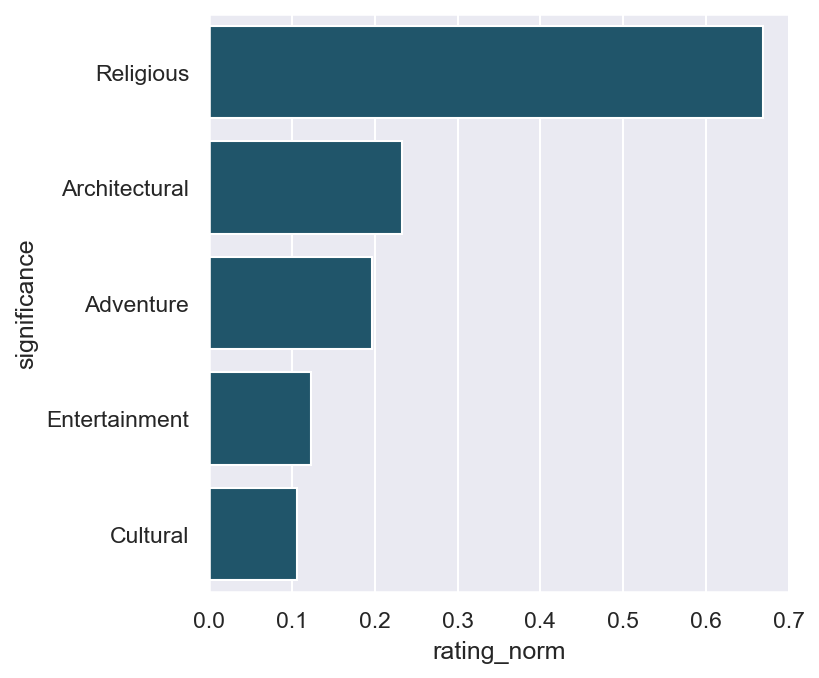

In [2131]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
x = 'significance'
colors = get_hex('Balistapus_undulatus')
# load dataset

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x]).mean('rating_norm').sort_values('rating_norm', ascending = False).head(5)

# Set the figure size
plt.figure(figsize=(5, 5))

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', color = colors[3]);

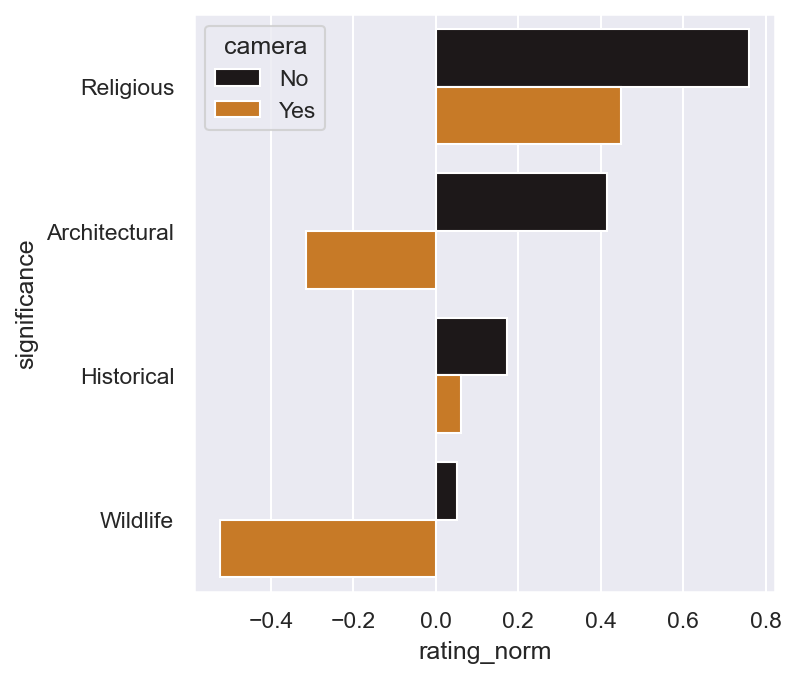

In [2155]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
x = 'significance'
colors = get_hex('Balistapus_undulatus')

# load dataset

filter_df = df[df['camera'] == 'No']
temp_df = df[df['significance'].isin(filter_df['significance'].unique())]

temp_df = temp_df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x, 'camera']).mean('rating_norm').sort_values('rating_norm', ascending = False)

# Set the figure size
plt.figure(figsize=(5, 5))

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', 
            hue = 'camera', palette = {'No':colors[4], 'Yes':colors[0]});

<Axes: xlabel='rating_norm', ylabel='type'>

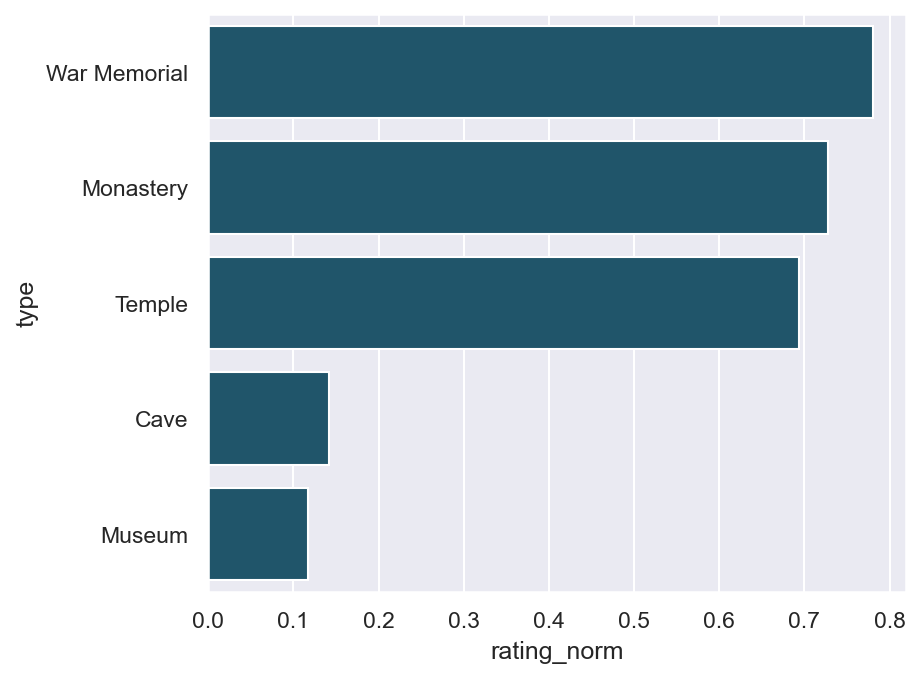

In [2229]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
colors = get_hex('Balistapus_undulatus')

x = 'type'

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x]).mean('rating_norm').sort_values('rating_norm', ascending = False).head(5)

# Set the figure size
plt.figure(figsize=(6, 5))

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', color = colors[3])

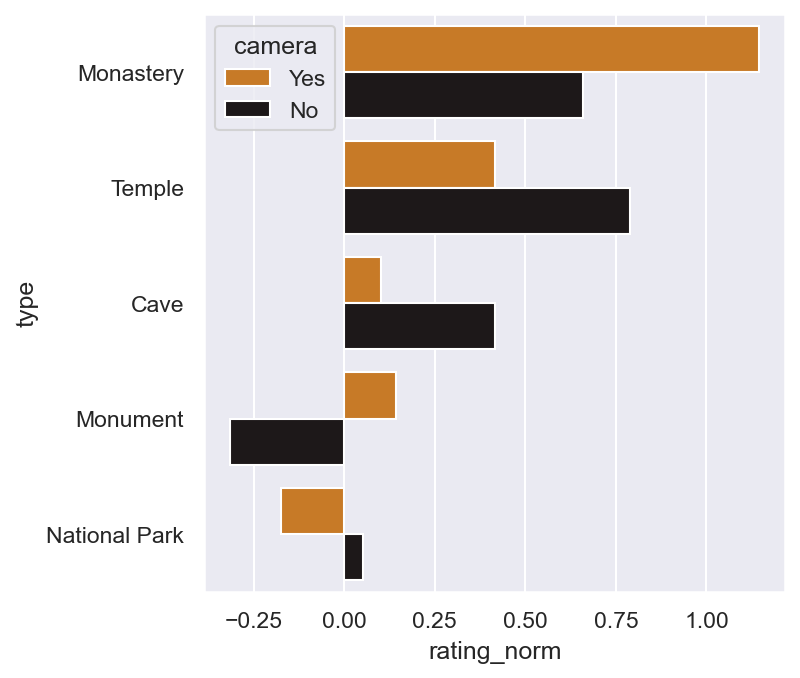

In [2233]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
colors = get_hex('Balistapus_undulatus')
x = 'type'
# load dataset

filter_df = df[df['camera'] == 'No']
temp_df = df[df[x].isin(filter_df[x].unique())]


temp_df1 = temp_df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x, 'camera']).mean('rating_norm')[['rating_norm']]


temp_df2 = temp_df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x]).mean('rating_norm').sort_values('rating_norm', ascending = False)[['rating_norm']].rename(columns={'rating_norm':'Avg'})

temp_df = temp_df1.join(temp_df2).sort_values('Avg', ascending = False)

# Set the figure size
plt.figure(figsize=(5, 5))

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', 
            hue = 'camera', palette = {'No':colors[4], 'Yes':colors[0]});